In [1]:
import sqlite3
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns #0.11.2
from datetime import datetime
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster import hierarchy 
from kneed import KneeLocator
from sklearn.cluster import AgglomerativeClustering
%matplotlib inline

In [2]:
from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture
from sklearn.cluster import MeanShift, DBSCAN, estimate_bandwidth

In [3]:
import pandas as pd 
import numpy as np

#opening df 
df= pd.read_sas('a2z_insurance.sas7bdat')

#making a copy of the df
dcopy=df.copy()

In [4]:
dcopy

CustID  FirstPolYear  BirthYear             EducDeg  MonthSal  \
0          1.0        1985.0     1982.0  b'2 - High School'    2177.0   
1          2.0        1981.0     1995.0  b'2 - High School'     677.0   
2          3.0        1991.0     1970.0        b'1 - Basic'    2277.0   
3          4.0        1990.0     1981.0      b'3 - BSc/MSc'    1099.0   
4          5.0        1986.0     1973.0      b'3 - BSc/MSc'    1763.0   
...        ...           ...        ...                 ...       ...   
10291  10292.0        1984.0     1949.0          b'4 - PhD'    3188.0   
10292  10293.0        1977.0     1952.0        b'1 - Basic'    2431.0   
10293  10294.0        1994.0     1976.0      b'3 - BSc/MSc'    2918.0   
10294  10295.0        1981.0     1977.0        b'1 - Basic'    1971.0   
10295  10296.0        1990.0     1981.0          b'4 - PhD'    2815.0   

       GeoLivArea  Children  CustMonVal  ClaimsRate  PremMotor  PremHousehold  \
0             1.0       1.0      380.97        0.39     375.85          79.45   
1             4.0       1.0     -131.13        1.12      77.46         416.20   
2             3.0       0.0      504.67        0.28     206.15         224.50   
3             4.0       1.0      -16.99        0.99     182.48          43.35   
4             4.0       1.0       35.23        0.90     338.62          47.80   
...           ...       ...         ...         ...        ...            ...   
10291         2.0       0.0       -0.11        0.96     393.74          49.45   
10292         3.0       0.0     1405.60        0.00     133.58        1035.75   
10293         1.0       1.0      524.10        0.21     403.63         132.80   
10294         2.0       1.0      250.05        0.65     188.59         211.15   
10295         1.0       1.0      463.75        0.27     414.08          94.45   

       PremHealth  PremLife  PremWork  
0          146.36     47.01     16.89  
1          116.69    194.48    106.13  
2          124.58     86.35     99.02  
3          311.17     35.34     28.34  
4          182.59     18.78     41.45  
...           ...       ...       ...  
10291      173.81      9.78     14.78  
10292      143.25     12.89    105.13  
10293      142.25     12.67      4.89  
10294      198.37     63.90    112.91  
10295      141.25      6.89     12.89  

[10296 rows x 14 columns]

In [5]:
#Checking if there are duplicate values (same rows as the original df/no duplicate values)
len(dcopy['CustID'].unique())

#3-Verifying clients that have a first policy year smaller than bday year (1997 rows that dont make sense)
dcopy[dcopy["FirstPolYear"]<dcopy["BirthYear"]]

#Swapping the values of these collumns (assumed it was a mistake) 
idx = (dcopy['FirstPolYear'] < dcopy['BirthYear'])
dcopy.loc[idx, ['FirstPolYear','BirthYear']] = dcopy.loc[idx, ['BirthYear','FirstPolYear']].values

#1- Checking if there are people above 100 years old and the ones that are not born yet
dcopy['Bday year']=dcopy.BirthYear.apply(lambda x:1 if (x>2016 or x<1916) else 0)

#droping the people that are above 100 years old and the ones that are not born yet (noisy data - reference year 2016)
dcopy.drop(dcopy.loc[dcopy['Bday year']==1].index,inplace=True) #1row

#deleting auxiliary column
del dcopy['Bday year']

#2- Verifying if the first year as a customer is between the defined range (no noisy values)
dcopy[dcopy['FirstPolYear']>2016] #1row found
dcopy[dcopy['FirstPolYear']<1916] #0rows found

dcopy.drop(dcopy.loc[dcopy['FirstPolYear']>2016].index,inplace=True)


#4-Checking if every customer has legal age to work (16 years)
dcopy.loc[(dcopy['BirthYear']>2000) & (dcopy['MonthSal']>0)] #no rows found

#5-Checking if there are people with 16 years or less that finished bachelor or Phd degrees (not found)
dcopy.loc[(dcopy['BirthYear']>=2000) & (dcopy['EducDeg']=="b'3 - BSc/MSc'")]
dcopy.loc[(dcopy['BirthYear']>=2000) & (dcopy['EducDeg']=="b'4 - PhD'")]

#Checking if everything is ok with the remaining columns (no issues found)
dcopy['Children'].unique() #no issues
dcopy['EducDeg'].unique() #no issues

dcopy['BirthYear'].min() #born in 1935 /ok!
dcopy['BirthYear'].max() #bron in 1998/ok!

dcopy.loc[(dcopy['BirthYear']>2000) & (dcopy['PremMotor']>0)] #no customers bellow 16 years old have PremMotor


dcopy

CustID  FirstPolYear  BirthYear             EducDeg  MonthSal  \
0          1.0        1985.0     1982.0  b'2 - High School'    2177.0   
1          2.0        1995.0     1981.0  b'2 - High School'     677.0   
2          3.0        1991.0     1970.0        b'1 - Basic'    2277.0   
3          4.0        1990.0     1981.0      b'3 - BSc/MSc'    1099.0   
4          5.0        1986.0     1973.0      b'3 - BSc/MSc'    1763.0   
...        ...           ...        ...                 ...       ...   
10291  10292.0        1984.0     1949.0          b'4 - PhD'    3188.0   
10292  10293.0        1977.0     1952.0        b'1 - Basic'    2431.0   
10293  10294.0        1994.0     1976.0      b'3 - BSc/MSc'    2918.0   
10294  10295.0        1981.0     1977.0        b'1 - Basic'    1971.0   
10295  10296.0        1990.0     1981.0          b'4 - PhD'    2815.0   

       GeoLivArea  Children  CustMonVal  ClaimsRate  PremMotor  PremHousehold  \
0             1.0       1.0      380.97        0.39     375.85          79.45   
1             4.0       1.0     -131.13        1.12      77.46         416.20   
2             3.0       0.0      504.67        0.28     206.15         224.50   
3             4.0       1.0      -16.99        0.99     182.48          43.35   
4             4.0       1.0       35.23        0.90     338.62          47.80   
...           ...       ...         ...         ...        ...            ...   
10291         2.0       0.0       -0.11        0.96     393.74          49.45   
10292         3.0       0.0     1405.60        0.00     133.58        1035.75   
10293         1.0       1.0      524.10        0.21     403.63         132.80   
10294         2.0       1.0      250.05        0.65     188.59         211.15   
10295         1.0       1.0      463.75        0.27     414.08          94.45   

       PremHealth  PremLife  PremWork  
0          146.36     47.01     16.89  
1          116.69    194.48    106.13  
2          124.58     86.35     99.02  
3          311.17     35.34     28.34  
4          182.59     18.78     41.45  
...           ...       ...       ...  
10291      173.81      9.78     14.78  
10292      143.25     12.89    105.13  
10293      142.25     12.67      4.89  
10294      198.37     63.90    112.91  
10295      141.25      6.89     12.89  

[10294 rows x 14 columns]

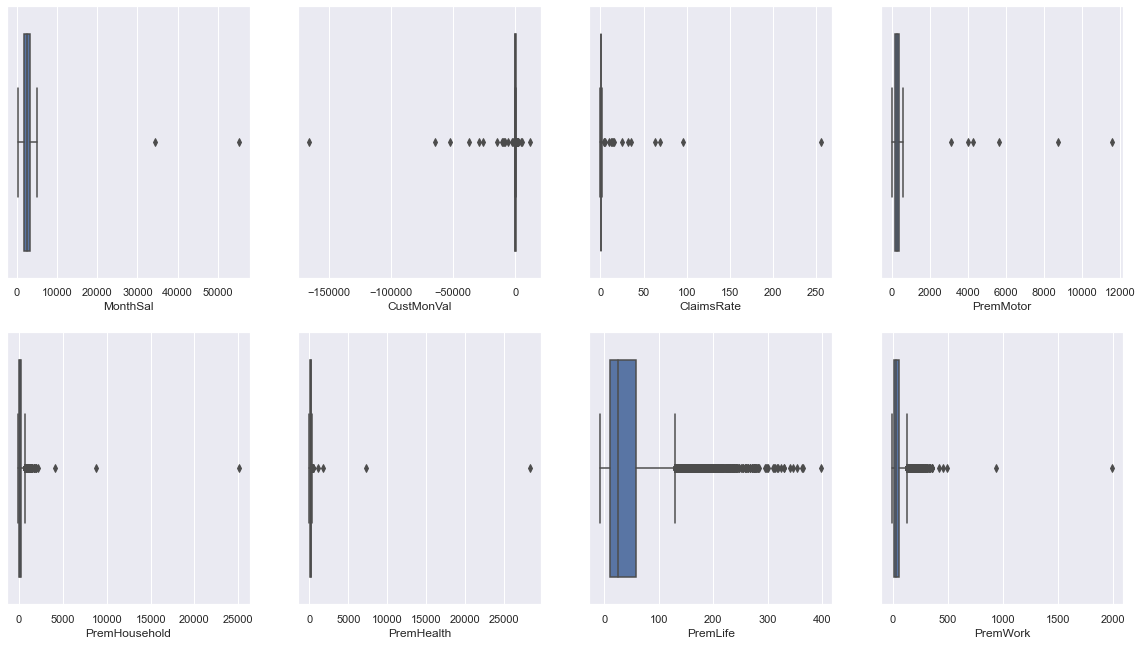

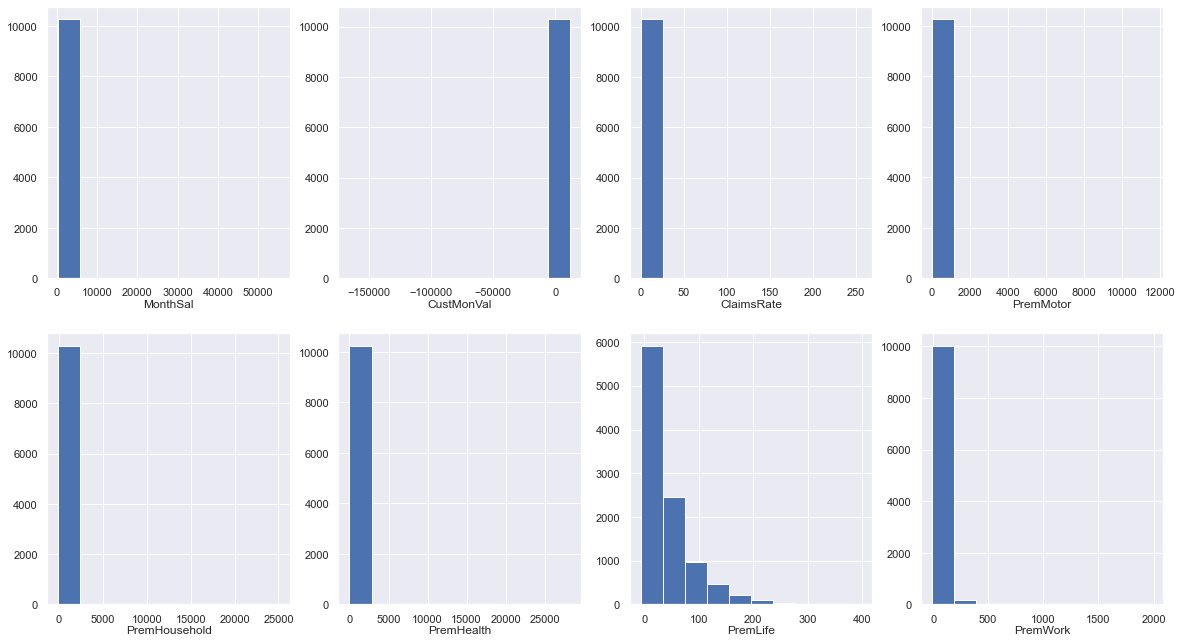

In [6]:
import matplotlib.pyplot as plt 
import seaborn as sns
import os
from math import ceil

# Defining metric and non-metric features. 
non_metric_features = ['CustID','FirstPolYear', 'BirthYear', 'EducDeg','Children','GeoLivArea']
metric_features = dcopy.columns.drop(non_metric_features).to_list()


# Boxplots
sns.set()

fig, axes=plt.subplots(2, ceil(len(metric_features)/2),figsize=(20,11))

for ax, feat in zip(axes.flatten(), metric_features):
    sns.boxplot(x=dcopy[feat],ax=ax)
    
plt.show()

#Histograms
sns.set()

fig, axes=plt.subplots(2, ceil(len(metric_features)/2),figsize=(20,11))

for ax, feat in zip(axes.flatten(), metric_features): 
    ax.hist(dcopy[feat])
    ax.set_title(feat, y=-0.13)
    
plt.show()


C:\Users\lucas\anaconda3\ANACONDA\envs\Data_Mining\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\lucas\anaconda3\ANACONDA\envs\Data_Mining\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\lucas\anaconda3\ANACONDA\envs\Data_Mining\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in a

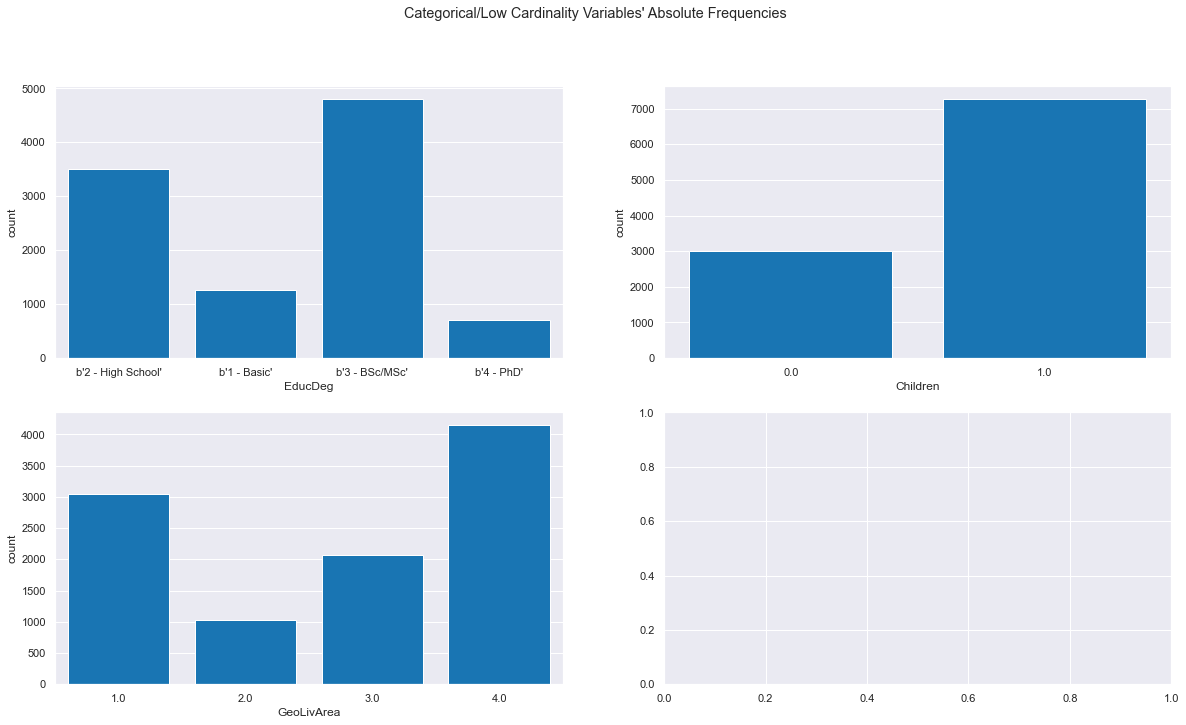

In [7]:
sns.set()

# Preparing the figure
fig, axes = plt.subplots(2, ceil(len(['EducDeg','Children','GeoLivArea']) / 2), figsize=(20, 11))

# Ploting data
for ax, feat in zip(axes.flatten(), ['EducDeg','Children','GeoLivArea']): 
    sns.countplot(df[feat].astype(object), ax=ax, color='#007acc')

title = "Categorical/Low Cardinality Variables' Absolute Frequencies"
plt.suptitle(title)

plt.show()

# Outlier removal

In [8]:
#To know these interval ranges, we did manually the filtering of the dataset outliers, using trial and error and 
#ploting each column, using closer ranges. For example (in Claims Rate):

#outliers3=dcopy.loc[dcopy['ClaimsRate']>3] ; we started with >50 because of the initial boxplot and ended up with >3 
#outliers3 ; checking how many outliers we are taking out
#dcopy=dcopy.loc[~dcopy['ClaimsRate'].isin(outliers3['ClaimsRate'])] ;removing the rows
#outliers(dcopy,'ClaimsRate'); Checking the new plot and then repeat the process, changing the intervals if necessary 

#Defined function to plot the outliers
#def outliers(df,column):
#    plt.figure(figsize=(12, 8))
#    sns.boxplot(df[column])
#    plt.xlabel(column)
#    plt.title('Outliers of '+column)

#outliers2=dcopy.loc[(dcopy['CustMonVal']<-1000) | (dcopy['CustMonVal']>1500)]



filters1 =(  
    ((dcopy['MonthSal']<=30000) | (dcopy['MonthSal'].isna()))
    &
    ((dcopy['CustMonVal']<=1500) | (dcopy['CustMonVal']>=-1000)|(dcopy['CustMonVal'].isna()))
    &
    ((dcopy['ClaimsRate']<=3)|(dcopy['ClaimsRate'].isna()))
    &
    ((dcopy['PremMotor']<=2000)|(dcopy['PremMotor'].isna()))
    &
    ((dcopy['PremHousehold']<=2000)|(dcopy['PremHousehold'].isna()))
    &
    ((dcopy['PremHealth']<=500)|(dcopy['PremHealth'].isna()))
    &
    ((dcopy['PremLife']<=290)|(dcopy['PremLife'].isna()))
    &
    ((dcopy['PremWork']<=400)|(dcopy['PremWork'].isna()))
)
        
df_1 = dcopy[filters1]

df_1

CustID  FirstPolYear  BirthYear             EducDeg  MonthSal  \
0          1.0        1985.0     1982.0  b'2 - High School'    2177.0   
1          2.0        1995.0     1981.0  b'2 - High School'     677.0   
2          3.0        1991.0     1970.0        b'1 - Basic'    2277.0   
3          4.0        1990.0     1981.0      b'3 - BSc/MSc'    1099.0   
4          5.0        1986.0     1973.0      b'3 - BSc/MSc'    1763.0   
...        ...           ...        ...                 ...       ...   
10291  10292.0        1984.0     1949.0          b'4 - PhD'    3188.0   
10292  10293.0        1977.0     1952.0        b'1 - Basic'    2431.0   
10293  10294.0        1994.0     1976.0      b'3 - BSc/MSc'    2918.0   
10294  10295.0        1981.0     1977.0        b'1 - Basic'    1971.0   
10295  10296.0        1990.0     1981.0          b'4 - PhD'    2815.0   

       GeoLivArea  Children  CustMonVal  ClaimsRate  PremMotor  PremHousehold  \
0             1.0       1.0      380.97        0.39     375.85          79.45   
1             4.0       1.0     -131.13        1.12      77.46         416.20   
2             3.0       0.0      504.67        0.28     206.15         224.50   
3             4.0       1.0      -16.99        0.99     182.48          43.35   
4             4.0       1.0       35.23        0.90     338.62          47.80   
...           ...       ...         ...         ...        ...            ...   
10291         2.0       0.0       -0.11        0.96     393.74          49.45   
10292         3.0       0.0     1405.60        0.00     133.58        1035.75   
10293         1.0       1.0      524.10        0.21     403.63         132.80   
10294         2.0       1.0      250.05        0.65     188.59         211.15   
10295         1.0       1.0      463.75        0.27     414.08          94.45   

       PremHealth  PremLife  PremWork  
0          146.36     47.01     16.89  
1          116.69    194.48    106.13  
2          124.58     86.35     99.02  
3          311.17     35.34     28.34  
4          182.59     18.78     41.45  
...           ...       ...       ...  
10291      173.81      9.78     14.78  
10292      143.25     12.89    105.13  
10293      142.25     12.67      4.89  
10294      198.37     63.90    112.91  
10295      141.25      6.89     12.89  

[10243 rows x 14 columns]

In [9]:
print('Percentage of data kept after removing outliers:', np.round(df_1.shape[0] / dcopy.shape[0], 4))

Percentage of data kept after removing outliers: 0.995


In [10]:
#TAKING CARE OF OUTLIERS

# Defining metric and non-metric features.
non_metric_features = ['CustID','FirstPolYear', 'BirthYear', 'EducDeg','Children','GeoLivArea']
metric_features = dcopy.columns.drop(non_metric_features).to_list()

q25 = dcopy.quantile(.25)
q75 = dcopy.quantile(.75)
iqr = (q75 - q25)

upper_lim = q75 + 1.5 * iqr
lower_lim = q25 - 1.5 * iqr

filters2 = []
for metric in metric_features:
    llim = lower_lim[metric]
    ulim = upper_lim[metric]
    filters2.append(df[metric].between(llim, ulim, inclusive=True))

filters2 = pd.Series(np.all(filters2, 0))
df_2 = dcopy[filters2]
print('Percentage of data kept after removing outliers:', np.round(df_2.shape[0] / dcopy.shape[0], 4))

Percentage of data kept after removing outliers: 0.8348


C:\Users\lucas\AppData\Local\Temp/ipykernel_1760/1547748984.py:18: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  filters2.append(df[metric].between(llim, ulim, inclusive=True))
C:\Users\lucas\AppData\Local\Temp/ipykernel_1760/1547748984.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_2 = dcopy[filters2]


In [11]:
df_3 = dcopy[(filters1 | filters2)]  
print('Percentage of data kept after removing outliers:', np.round(df_3.shape[0] / dcopy.shape[0], 4))

Percentage of data kept after removing outliers: 0.995


C:\Users\lucas\AppData\Local\Temp/ipykernel_1760/2013683396.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_3 = dcopy[(filters1 | filters2)]


In [12]:
df_outliers1=dcopy[~(filters1 | filters2)] #storing the removed outliers in a dataframe to be used later

C:\Users\lucas\AppData\Local\Temp/ipykernel_1760/1333001687.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_outliers1=dcopy[~(filters1 | filters2)]


In [13]:
df_3 #dataframe without outliers

CustID  FirstPolYear  BirthYear             EducDeg  MonthSal  \
0          1.0        1985.0     1982.0  b'2 - High School'    2177.0   
1          2.0        1995.0     1981.0  b'2 - High School'     677.0   
2          3.0        1991.0     1970.0        b'1 - Basic'    2277.0   
3          4.0        1990.0     1981.0      b'3 - BSc/MSc'    1099.0   
4          5.0        1986.0     1973.0      b'3 - BSc/MSc'    1763.0   
...        ...           ...        ...                 ...       ...   
10291  10292.0        1984.0     1949.0          b'4 - PhD'    3188.0   
10292  10293.0        1977.0     1952.0        b'1 - Basic'    2431.0   
10293  10294.0        1994.0     1976.0      b'3 - BSc/MSc'    2918.0   
10294  10295.0        1981.0     1977.0        b'1 - Basic'    1971.0   
10295  10296.0        1990.0     1981.0          b'4 - PhD'    2815.0   

       GeoLivArea  Children  CustMonVal  ClaimsRate  PremMotor  PremHousehold  \
0             1.0       1.0      380.97        0.39     375.85          79.45   
1             4.0       1.0     -131.13        1.12      77.46         416.20   
2             3.0       0.0      504.67        0.28     206.15         224.50   
3             4.0       1.0      -16.99        0.99     182.48          43.35   
4             4.0       1.0       35.23        0.90     338.62          47.80   
...           ...       ...         ...         ...        ...            ...   
10291         2.0       0.0       -0.11        0.96     393.74          49.45   
10292         3.0       0.0     1405.60        0.00     133.58        1035.75   
10293         1.0       1.0      524.10        0.21     403.63         132.80   
10294         2.0       1.0      250.05        0.65     188.59         211.15   
10295         1.0       1.0      463.75        0.27     414.08          94.45   

       PremHealth  PremLife  PremWork  
0          146.36     47.01     16.89  
1          116.69    194.48    106.13  
2          124.58     86.35     99.02  
3          311.17     35.34     28.34  
4          182.59     18.78     41.45  
...           ...       ...       ...  
10291      173.81      9.78     14.78  
10292      143.25     12.89    105.13  
10293      142.25     12.67      4.89  
10294      198.37     63.90    112.91  
10295      141.25      6.89     12.89  

[10243 rows x 14 columns]

# Missing Values Treatment

In [14]:
#counting missing values after removing outliers
print(df_3.isna().sum())

#checking the mode of non_metric features to fill missing values
modes = df_3[non_metric_features].mode().loc[0]
modes

CustID             0
FirstPolYear      30
BirthYear         17
EducDeg           17
MonthSal          36
GeoLivArea         1
Children          21
CustMonVal         0
ClaimsRate         0
PremMotor         33
PremHousehold      0
PremHealth        42
PremLife         104
PremWork          86
dtype: int64


CustID                     1.0
FirstPolYear            1994.0
BirthYear               1977.0
EducDeg         b'3 - BSc/MSc'
Children                   1.0
GeoLivArea                 4.0
Name: 0, dtype: object

In [15]:
#replacing missing values in non_metric features
df_3.fillna(modes, inplace=True)
df_3.isna().sum()

C:\Users\lucas\anaconda3\ANACONDA\envs\Data_Mining\lib\site-packages\pandas\core\generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


CustID             0
FirstPolYear       0
BirthYear          0
EducDeg            0
MonthSal          36
GeoLivArea         0
Children           0
CustMonVal         0
ClaimsRate         0
PremMotor         33
PremHousehold      0
PremHealth        42
PremLife         104
PremWork          86
dtype: int64

In [16]:
#checking the mean of metric_features to fill missing values
means = df_3[metric_features].mean()
means

MonthSal         2501.038307
CustMonVal        218.477567
ClaimsRate          0.679548
PremMotor         297.494180
PremHousehold     206.410246
PremHealth        168.035946
PremLife           41.348891
PremWork           40.850883
dtype: float64

In [17]:
#replacing missing values in metric features
df_3.fillna(means, inplace=True)
df_3.isna().sum()

CustID           0
FirstPolYear     0
BirthYear        0
EducDeg          0
MonthSal         0
GeoLivArea       0
Children         0
CustMonVal       0
ClaimsRate       0
PremMotor        0
PremHousehold    0
PremHealth       0
PremLife         0
PremWork         0
dtype: int64

In [18]:
df_3[metric_features]

MonthSal  CustMonVal  ClaimsRate  PremMotor  PremHousehold  PremHealth  \
0        2177.0      380.97        0.39     375.85          79.45      146.36   
1         677.0     -131.13        1.12      77.46         416.20      116.69   
2        2277.0      504.67        0.28     206.15         224.50      124.58   
3        1099.0      -16.99        0.99     182.48          43.35      311.17   
4        1763.0       35.23        0.90     338.62          47.80      182.59   
...         ...         ...         ...        ...            ...         ...   
10291    3188.0       -0.11        0.96     393.74          49.45      173.81   
10292    2431.0     1405.60        0.00     133.58        1035.75      143.25   
10293    2918.0      524.10        0.21     403.63         132.80      142.25   
10294    1971.0      250.05        0.65     188.59         211.15      198.37   
10295    2815.0      463.75        0.27     414.08          94.45      141.25   

       PremLife  PremWork  
0         47.01     16.89  
1        194.48    106.13  
2         86.35     99.02  
3         35.34     28.34  
4         18.78     41.45  
...         ...       ...  
10291      9.78     14.78  
10292     12.89    105.13  
10293     12.67      4.89  
10294     63.90    112.91  
10295      6.89     12.89  

[10243 rows x 8 columns]

In [19]:
metric_features

['MonthSal',
 'CustMonVal',
 'ClaimsRate',
 'PremMotor',
 'PremHousehold',
 'PremHealth',
 'PremLife',
 'PremWork']

In [20]:
# check descriptive statistics
df_3.describe(include="all").T

count unique             top  freq         mean          std  \
CustID         10243.0    NaN             NaN   NaN  5152.745485  2970.274326   
FirstPolYear   10243.0    NaN             NaN   NaN  1987.649224     6.540507   
BirthYear      10243.0    NaN             NaN   NaN  1966.446646    15.451379   
EducDeg          10243      4  b'3 - BSc/MSc'  4798          NaN          NaN   
MonthSal       10243.0    NaN             NaN   NaN  2501.038307   981.067656   
GeoLivArea     10243.0    NaN             NaN   NaN     2.709655     1.266659   
Children       10243.0    NaN             NaN   NaN     0.707703      0.45484   
CustMonVal     10243.0    NaN             NaN   NaN   218.477567   258.535377   
ClaimsRate     10243.0    NaN             NaN   NaN     0.679548     0.318814   
PremMotor      10243.0    NaN             NaN   NaN    297.49418   137.490268   
PremHousehold  10243.0    NaN             NaN   NaN   206.410246   235.267697   
PremHealth     10243.0    NaN             NaN   NaN   168.035946    74.010136   
PremLife       10243.0    NaN             NaN   NaN    41.348891     45.72206   
PremWork       10243.0    NaN             NaN   NaN    40.850883    46.160087   

                  min     25%          50%     75%      max  
CustID            1.0  2584.5       5151.0  7723.5  10296.0  
FirstPolYear   1974.0  1982.0       1988.0  1993.0   2001.0  
BirthYear      1935.0  1953.0       1968.0  1979.0   1998.0  
EducDeg           NaN     NaN          NaN     NaN      NaN  
MonthSal        333.0  1714.0  2501.038307  3289.0   5021.0  
GeoLivArea        1.0     1.0          3.0     4.0      4.0  
Children          0.0     0.0          1.0     1.0      1.0  
CustMonVal    -416.73  -9.165       187.25  399.36  2054.07  
ClaimsRate        0.0    0.39         0.72    0.98     1.62  
PremMotor       -4.11  192.26        298.5  407.52   585.22  
PremHousehold   -75.0   49.45        132.8   289.5   1957.6  
PremHealth      -2.11  111.91       163.03  219.04   442.86  
PremLife         -7.0    9.89        26.45    56.9   284.61  
PremWork        -12.0   10.78        26.34   56.01   353.18

In [21]:
df_3.dtypes #checking the types

CustID           float64
FirstPolYear     float64
BirthYear        float64
EducDeg           object
MonthSal         float64
GeoLivArea       float64
Children         float64
CustMonVal       float64
ClaimsRate       float64
PremMotor        float64
PremHousehold    float64
PremHealth       float64
PremLife         float64
PremWork         float64
dtype: object

## Redundancy and Relevancy

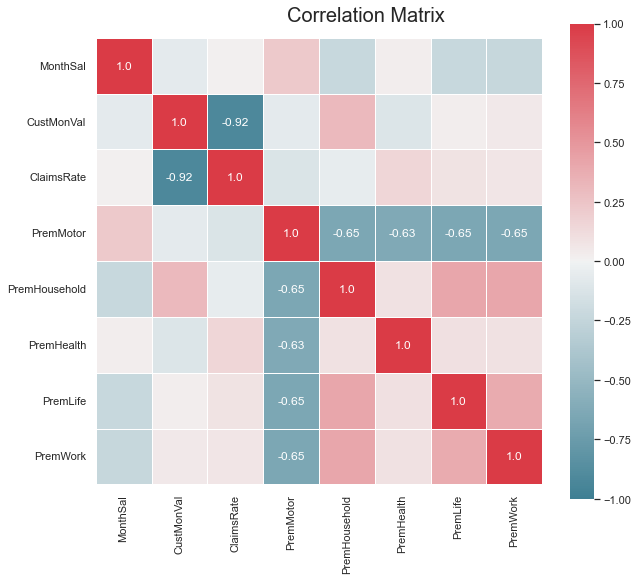

In [22]:
#TRYING TO SPOT SOME REDUNDANCY BY THE CORRELATION MATRIX 

# Preparing figure
fig = plt.figure(figsize=(10, 8))

# Obtaining the correlation matrix
corr = np.round(df_3[metric_features].corr(method="pearson"), decimals=2)

mask_annot = np.absolute(corr.values) >= 0.5
annot = np.where(mask_annot, corr.values, np.full(corr.shape,"")) # Try to understand what this np.where() does

# Ploting
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix", fontsize=20)


plt.show()

In [23]:
#correlation between Claimsrate and CustMonVal is considered high (0.92) so decided to drop ClaimsRate

df_3.drop(columns='ClaimsRate',inplace=True)
metric_features.remove('ClaimsRate')
df_3

C:\Users\lucas\anaconda3\ANACONDA\envs\Data_Mining\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


CustID  FirstPolYear  BirthYear             EducDeg  MonthSal  \
0          1.0        1985.0     1982.0  b'2 - High School'    2177.0   
1          2.0        1995.0     1981.0  b'2 - High School'     677.0   
2          3.0        1991.0     1970.0        b'1 - Basic'    2277.0   
3          4.0        1990.0     1981.0      b'3 - BSc/MSc'    1099.0   
4          5.0        1986.0     1973.0      b'3 - BSc/MSc'    1763.0   
...        ...           ...        ...                 ...       ...   
10291  10292.0        1984.0     1949.0          b'4 - PhD'    3188.0   
10292  10293.0        1977.0     1952.0        b'1 - Basic'    2431.0   
10293  10294.0        1994.0     1976.0      b'3 - BSc/MSc'    2918.0   
10294  10295.0        1981.0     1977.0        b'1 - Basic'    1971.0   
10295  10296.0        1990.0     1981.0          b'4 - PhD'    2815.0   

       GeoLivArea  Children  CustMonVal  PremMotor  PremHousehold  PremHealth  \
0             1.0       1.0      380.97     375.85          79.45      146.36   
1             4.0       1.0     -131.13      77.46         416.20      116.69   
2             3.0       0.0      504.67     206.15         224.50      124.58   
3             4.0       1.0      -16.99     182.48          43.35      311.17   
4             4.0       1.0       35.23     338.62          47.80      182.59   
...           ...       ...         ...        ...            ...         ...   
10291         2.0       0.0       -0.11     393.74          49.45      173.81   
10292         3.0       0.0     1405.60     133.58        1035.75      143.25   
10293         1.0       1.0      524.10     403.63         132.80      142.25   
10294         2.0       1.0      250.05     188.59         211.15      198.37   
10295         1.0       1.0      463.75     414.08          94.45      141.25   

       PremLife  PremWork  
0         47.01     16.89  
1        194.48    106.13  
2         86.35     99.02  
3         35.34     28.34  
4         18.78     41.45  
...         ...       ...  
10291      9.78     14.78  
10292     12.89    105.13  
10293     12.67      4.89  
10294     63.90    112.91  
10295      6.89     12.89  

[10243 rows x 13 columns]

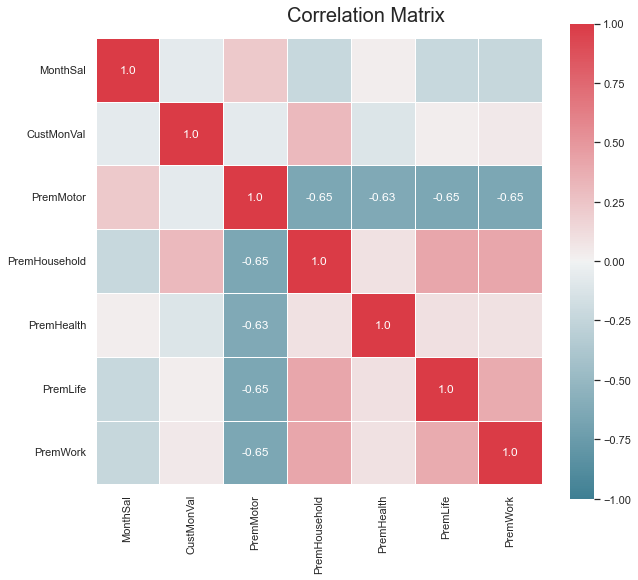

In [24]:
# Preparing the figure / checking for redundancy
fig = plt.figure(figsize=(10, 8))

# Obtaining the correlation matrix
corr = np.round(df_3[metric_features].corr(method="pearson"), decimals=2)

mask_annot = np.absolute(corr.values) >= 0.5
annot = np.where(mask_annot, corr.values, np.full(corr.shape,"")) # Try to understand what this np.where() does

# Ploting heatmap
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)


fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix", fontsize=20)

plt.show()

# Data Normalization

In [25]:
#using MinMaxScaler
df_minmax = df_3.copy()

scaler = MinMaxScaler()
scaled_feat = scaler.fit_transform(df_minmax[metric_features])
scaled_feat

df_minmax[metric_features] = scaled_feat
df_minmax.head()

CustID  FirstPolYear  BirthYear             EducDeg  MonthSal  GeoLivArea  \
0     1.0        1985.0     1982.0  b'2 - High School'  0.393345         1.0   
1     2.0        1995.0     1981.0  b'2 - High School'  0.073379         4.0   
2     3.0        1991.0     1970.0        b'1 - Basic'  0.414676         3.0   
3     4.0        1990.0     1981.0      b'3 - BSc/MSc'  0.163396         4.0   
4     5.0        1986.0     1973.0      b'3 - BSc/MSc'  0.305034         4.0   

   Children  CustMonVal  PremMotor  PremHousehold  PremHealth  PremLife  \
0       1.0    0.322851   0.644732       0.075986    0.333663  0.185213   
1       1.0    0.115590   0.138411       0.241661    0.266984  0.690923   
2       0.0    0.372916   0.356778       0.147348    0.284716  0.320119   
3       1.0    0.161786   0.316614       0.058226    0.704047  0.145194   
4       1.0    0.182921   0.581559       0.060415    0.415084  0.088406   

   PremWork  
0  0.079112  
1  0.323484  
2  0.304014  
3  0.110466  
4  0.146366

In [26]:
#creating dummies that correspond to each categories of EducDeg
rated_dummies = pd.get_dummies(df_minmax.EducDeg)
df_minmax=pd.concat([df_minmax, rated_dummies], axis=1)
df_minmax.drop(columns='EducDeg',inplace=True)

rated_dummies = pd.get_dummies(df_minmax.GeoLivArea)
df_minmax=pd.concat([df_minmax, rated_dummies], axis=1)
df_minmax.drop(columns='GeoLivArea',inplace=True)

df_minmax.rename(columns={1.0: "Geo1", 2.0: "Geo2",3.0: "Geo3",4.0: "Geo4"},inplace=True)

df_minmax

CustID  FirstPolYear  BirthYear  MonthSal  Children  CustMonVal  \
0          1.0        1985.0     1982.0  0.393345       1.0    0.322851   
1          2.0        1995.0     1981.0  0.073379       1.0    0.115590   
2          3.0        1991.0     1970.0  0.414676       0.0    0.372916   
3          4.0        1990.0     1981.0  0.163396       1.0    0.161786   
4          5.0        1986.0     1973.0  0.305034       1.0    0.182921   
...        ...           ...        ...       ...       ...         ...   
10291  10292.0        1984.0     1949.0  0.609002       0.0    0.168617   
10292  10293.0        1977.0     1952.0  0.447526       0.0    0.737547   
10293  10294.0        1994.0     1976.0  0.551408       1.0    0.380780   
10294  10295.0        1981.0     1977.0  0.349403       1.0    0.269864   
10295  10296.0        1990.0     1981.0  0.529437       1.0    0.356354   

       PremMotor  PremHousehold  PremHealth  PremLife  PremWork  b'1 - Basic'  \
0       0.644732       0.075986    0.333663  0.185213  0.079112             0   
1       0.138411       0.241661    0.266984  0.690923  0.323484             0   
2       0.356778       0.147348    0.284716  0.320119  0.304014             1   
3       0.316614       0.058226    0.704047  0.145194  0.110466             0   
4       0.581559       0.060415    0.415084  0.088406  0.146366             0   
...          ...            ...         ...       ...       ...           ...   
10291   0.675089       0.061227    0.395352  0.057543  0.073334             0   
10292   0.233638       0.546468    0.326674  0.068208  0.320746             1   
10293   0.691870       0.102234    0.324426  0.067453  0.046251             0   
10294   0.326981       0.140780    0.450547  0.243133  0.342050             1   
10295   0.709602       0.083366    0.322179  0.047632  0.068158             0   

       b'2 - High School'  b'3 - BSc/MSc'  b'4 - PhD'  Geo1  Geo2  Geo3  Geo4  
0                       1               0           0     1     0     0     0  
1                       1               0           0     0     0     0     1  
2                       0               0           0     0     0     1     0  
3                       0               1           0     0     0     0     1  
4                       0               1           0     0     0     0     1  
...                   ...             ...         ...   ...   ...   ...   ...  
10291                   0               0           1     0     1     0     0  
10292                   0               0           0     0     0     1     0  
10293                   0               1           0     1     0     0     0  
10294                   0               0           0     0     1     0     0  
10295                   0               0           1     1     0     0     0  

[10243 rows x 19 columns]

## Attempting PCA 

In [27]:
#To overcome possible dimensionality problems, we conducted PCA analysis

df_pca = df_minmax.copy()
df_pca[metric_features]

MonthSal  CustMonVal  PremMotor  PremHousehold  PremHealth  PremLife  \
0      0.393345    0.322851   0.644732       0.075986    0.333663  0.185213   
1      0.073379    0.115590   0.138411       0.241661    0.266984  0.690923   
2      0.414676    0.372916   0.356778       0.147348    0.284716  0.320119   
3      0.163396    0.161786   0.316614       0.058226    0.704047  0.145194   
4      0.305034    0.182921   0.581559       0.060415    0.415084  0.088406   
...         ...         ...        ...            ...         ...       ...   
10291  0.609002    0.168617   0.675089       0.061227    0.395352  0.057543   
10292  0.447526    0.737547   0.233638       0.546468    0.326674  0.068208   
10293  0.551408    0.380780   0.691870       0.102234    0.324426  0.067453   
10294  0.349403    0.269864   0.326981       0.140780    0.450547  0.243133   
10295  0.529437    0.356354   0.709602       0.083366    0.322179  0.047632   

       PremWork  
0      0.079112  
1      0.323484  
2      0.304014  
3      0.110466  
4      0.146366  
...         ...  
10291  0.073334  
10292  0.320746  
10293  0.046251  
10294  0.342050  
10295  0.068158  

[10243 rows x 7 columns]

In [28]:
# Use PCA to reduce dimensionality of data
pca = PCA()
pca_feat = pca.fit_transform(df_pca[metric_features])
pca_feat  

array([[-1.19130639e-01, -1.09822239e-01, -7.14281662e-03, ...,
        -7.96021736e-02, -6.64172976e-02, -1.30065934e-02],
       [ 6.15367138e-01, -3.38256751e-01,  2.30401629e-01, ...,
         1.65731464e-02,  3.25148236e-02,  9.59815240e-03],
       [ 2.04921889e-01, -7.04519912e-02,  1.84792959e-01, ...,
         2.72383175e-02, -1.23067801e-01,  3.07611508e-02],
       ...,
       [-2.45453365e-01,  1.79137189e-02,  1.21698638e-02, ...,
        -8.97885874e-02, -5.00227119e-02,  3.93690430e-04],
       [ 2.73731933e-01, -4.39366052e-02, -7.25984271e-04, ...,
         1.10085873e-01, -8.55472693e-02, -1.72521279e-02],
       [-2.59794169e-01, -3.93078816e-03, -8.01505121e-03, ...,
        -5.20603331e-02, -5.33793327e-02, -3.96865845e-03]])

In [29]:
# Output PCA table
pd.DataFrame(
    {"Eigenvalue": pca.explained_variance_,
     "Difference": np.insert(np.diff(pca.explained_variance_), 0, 0),
     "Proportion": pca.explained_variance_ratio_,
     "Cumulative": np.cumsum(pca.explained_variance_ratio_)},
    index=range(1, pca.n_components_ + 1)
)

Eigenvalue  Difference  Proportion  Cumulative
1    0.092822    0.000000    0.486501    0.486501
2    0.042656   -0.050166    0.223571    0.710072
3    0.023811   -0.018845    0.124801    0.834873
4    0.013607   -0.010205    0.071316    0.906189
5    0.011083   -0.002524    0.058087    0.964276
6    0.006484   -0.004599    0.033984    0.998260
7    0.000332   -0.006152    0.001740    1.000000

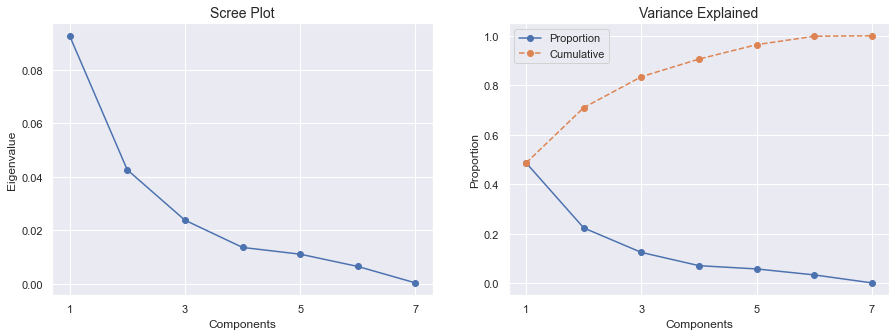

In [30]:
#Ploting the PCA results

# figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# draw plots
ax1.plot(pca.explained_variance_, marker=".", markersize=12)
ax2.plot(pca.explained_variance_ratio_, marker=".", markersize=12, label="Proportion")
ax2.plot(np.cumsum(pca.explained_variance_ratio_), marker=".", markersize=12, linestyle="--", label="Cumulative")

# customizations
ax2.legend()
ax1.set_title("Scree Plot", fontsize=14)
ax2.set_title("Variance Explained", fontsize=14)
ax1.set_ylabel("Eigenvalue")
ax2.set_ylabel("Proportion")
ax1.set_xlabel("Components")
ax2.set_xlabel("Components")
ax1.set_xticks(range(0, pca.n_components_, 2))
ax1.set_xticklabels(range(1, pca.n_components_ + 1, 2))
ax2.set_xticks(range(0, pca.n_components_, 2))
ax2.set_xticklabels(range(1, pca.n_components_ + 1, 2))

plt.show()

In [31]:
# Perform PCA again with the number of principal components you want to retain
pca = PCA(n_components=5) #chose 5components to have 95% of variance explained
pca_feat = pca.fit_transform(df_pca[metric_features])
pca_feat_names = [f"PC{i}" for i in range(pca.n_components_)]
pca_df = pd.DataFrame(pca_feat, index=df_pca.index, columns=pca_feat_names) 
pca_df

PC0       PC1       PC2       PC3       PC4
0     -0.119131 -0.109822 -0.007143 -0.022715 -0.079602
1      0.615367 -0.338257  0.230402 -0.308031  0.016573
2      0.204922 -0.070452  0.184793  0.024287  0.027238
3      0.288583 -0.074169 -0.388175 -0.089198 -0.005267
4     -0.046950 -0.128333 -0.152879 -0.043350  0.065860
...         ...       ...       ...       ...       ...
10291 -0.240106  0.115062 -0.058041 -0.045367  0.036467
10292  0.322685 -0.022561  0.216973  0.594598 -0.113108
10293 -0.245453  0.017914  0.012170  0.091671 -0.089789
10294  0.273732 -0.043937 -0.000726  0.008383  0.110086
10295 -0.259794 -0.003931 -0.008015  0.082529 -0.052060

[10243 rows x 5 columns]

In [32]:
# Reassigning df to contain pca variables
df_pca = pd.concat([df_pca, pca_df], axis=1)
df_pca.head()

CustID  FirstPolYear  BirthYear  MonthSal  Children  CustMonVal  PremMotor  \
0     1.0        1985.0     1982.0  0.393345       1.0    0.322851   0.644732   
1     2.0        1995.0     1981.0  0.073379       1.0    0.115590   0.138411   
2     3.0        1991.0     1970.0  0.414676       0.0    0.372916   0.356778   
3     4.0        1990.0     1981.0  0.163396       1.0    0.161786   0.316614   
4     5.0        1986.0     1973.0  0.305034       1.0    0.182921   0.581559   

   PremHousehold  PremHealth  PremLife  ...  b'4 - PhD'  Geo1  Geo2  Geo3  \
0       0.075986    0.333663  0.185213  ...           0     1     0     0   
1       0.241661    0.266984  0.690923  ...           0     0     0     0   
2       0.147348    0.284716  0.320119  ...           0     0     0     1   
3       0.058226    0.704047  0.145194  ...           0     0     0     0   
4       0.060415    0.415084  0.088406  ...           0     0     0     0   

   Geo4       PC0       PC1       PC2       PC3       PC4  
0     0 -0.119131 -0.109822 -0.007143 -0.022715 -0.079602  
1     1  0.615367 -0.338257  0.230402 -0.308031  0.016573  
2     0  0.204922 -0.070452  0.184793  0.024287  0.027238  
3     1  0.288583 -0.074169 -0.388175 -0.089198 -0.005267  
4     1 -0.046950 -0.128333 -0.152879 -0.043350  0.065860  

[5 rows x 24 columns]

In [33]:
def _color_red_or_green(val):
    if val < -0.45:
        color = 'background-color: red'
    elif val > 0.45:
        color = 'background-color: green'
    else:
        color = ''
    return color

# Interpreting each Principal Component
loadings = df_pca[metric_features + pca_feat_names].corr().loc[metric_features, pca_feat_names]
loadings.style.applymap(_color_red_or_green)

In [34]:
#We conclude from the PCA results that it is not worth to reduce dimensionality through PCA, because we would not be able
#to reduce much dimensionality (looking at variance explained and eigenvalues) and the core meaning 
#of the variables would be lost

# Removing outliers again after filling the missing values (dbscan)

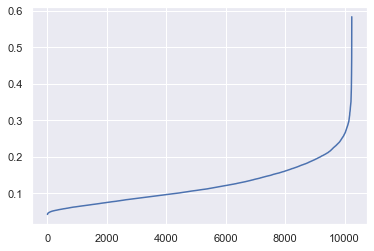

In [35]:
neigh = NearestNeighbors(n_neighbors=15) #finding the best number of eps
neigh.fit(df_minmax[metric_features])
distances, _ = neigh.kneighbors(df_minmax[metric_features])
distances = np.sort(distances[:, -1])
plt.plot(distances)
plt.show()

In [36]:
dbscan = DBSCAN(eps=0.25, min_samples=14, n_jobs=4) #applying dbscan for outlier removal
dbscan_labels = dbscan.fit_predict(df_minmax[metric_features])
df_minmax['label']=dbscan_labels

In [37]:
outliers2=df_minmax.loc[df_minmax['label']==-1].copy() #storing the removed outliers in a dataframe to be used later
df_minmax=df_minmax.loc[df_minmax['label']==0]
df_minmax.drop(columns='label',inplace=True)

C:\Users\lucas\anaconda3\ANACONDA\envs\Data_Mining\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [38]:
df_minmax # final dataframe without outliers and with filled missing values that will be used in the algorithms 

CustID  FirstPolYear  BirthYear  MonthSal  Children  CustMonVal  \
0          1.0        1985.0     1982.0  0.393345       1.0    0.322851   
1          2.0        1995.0     1981.0  0.073379       1.0    0.115590   
2          3.0        1991.0     1970.0  0.414676       0.0    0.372916   
3          4.0        1990.0     1981.0  0.163396       1.0    0.161786   
4          5.0        1986.0     1973.0  0.305034       1.0    0.182921   
...        ...           ...        ...       ...       ...         ...   
10291  10292.0        1984.0     1949.0  0.609002       0.0    0.168617   
10292  10293.0        1977.0     1952.0  0.447526       0.0    0.737547   
10293  10294.0        1994.0     1976.0  0.551408       1.0    0.380780   
10294  10295.0        1981.0     1977.0  0.349403       1.0    0.269864   
10295  10296.0        1990.0     1981.0  0.529437       1.0    0.356354   

       PremMotor  PremHousehold  PremHealth  PremLife  PremWork  b'1 - Basic'  \
0       0.644732       0.075986    0.333663  0.185213  0.079112             0   
1       0.138411       0.241661    0.266984  0.690923  0.323484             0   
2       0.356778       0.147348    0.284716  0.320119  0.304014             1   
3       0.316614       0.058226    0.704047  0.145194  0.110466             0   
4       0.581559       0.060415    0.415084  0.088406  0.146366             0   
...          ...            ...         ...       ...       ...           ...   
10291   0.675089       0.061227    0.395352  0.057543  0.073334             0   
10292   0.233638       0.546468    0.326674  0.068208  0.320746             1   
10293   0.691870       0.102234    0.324426  0.067453  0.046251             0   
10294   0.326981       0.140780    0.450547  0.243133  0.342050             1   
10295   0.709602       0.083366    0.322179  0.047632  0.068158             0   

       b'2 - High School'  b'3 - BSc/MSc'  b'4 - PhD'  Geo1  Geo2  Geo3  Geo4  
0                       1               0           0     1     0     0     0  
1                       1               0           0     0     0     0     1  
2                       0               0           0     0     0     1     0  
3                       0               1           0     0     0     0     1  
4                       0               1           0     0     0     0     1  
...                   ...             ...         ...   ...   ...   ...   ...  
10291                   0               0           1     0     1     0     0  
10292                   0               0           0     0     0     1     0  
10293                   0               1           0     1     0     0     0  
10294                   0               0           0     0     1     0     0  
10295                   0               0           1     1     0     0     0  

[10188 rows x 19 columns]

## Feature Engineering (trying with total premium)

In [39]:
#Due to the conclusions above (pca), instead we decided to combine premium variables and adding them to the metric_features

df_3['Total_Premiums'] = df_3['PremMotor'] + df_3['PremHousehold'] + df_3['PremHealth'] + df_3['PremLife'] + df_3['PremWork']
metric_features.append('Total_Premiums')

C:\Users\lucas\AppData\Local\Temp/ipykernel_1760/2451455974.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3['Total_Premiums'] = df_3['PremMotor'] + df_3['PremHousehold'] + df_3['PremHealth'] + df_3['PremLife'] + df_3['PremWork']


In [40]:
#dropping the columns of the premium variables
df_3.drop(columns=['PremMotor','PremHousehold','PremHealth','PremLife','PremWork'],inplace=True)

C:\Users\lucas\anaconda3\ANACONDA\envs\Data_Mining\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [41]:
#removing these variables from metric_features
metric_features.remove('PremMotor')
metric_features.remove('PremHousehold')
metric_features.remove('PremHealth')
metric_features.remove('PremLife')
metric_features.remove('PremWork')

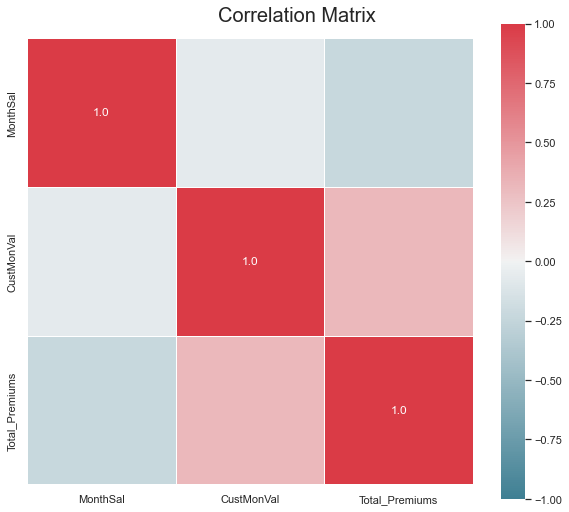

In [42]:
# Preparing the figure
fig = plt.figure(figsize=(10, 8))

# Obtaining the correlation matrix
corr = np.round(df_3[metric_features].corr(method="pearson"), decimals=2)


mask_annot = np.absolute(corr.values) >= 0.5
annot = np.where(mask_annot, corr.values, np.full(corr.shape,"")) # Try to understand what this np.where() does

# Ploting the heatmap
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)


fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix", fontsize=20)

plt.show()

In [43]:
#Normalizing data again since we have a new variable

#using MinMaxScaler
df_minmaxtp = df_3.copy()

scaler = MinMaxScaler()
scaled_feat = scaler.fit_transform(df_minmaxtp[metric_features])
scaled_feat

df_minmaxtp[metric_features] = scaled_feat
df_minmaxtp.head()

CustID  FirstPolYear  BirthYear             EducDeg  MonthSal  GeoLivArea  \
0     1.0        1985.0     1982.0  b'2 - High School'  0.393345         1.0   
1     2.0        1995.0     1981.0  b'2 - High School'  0.073379         4.0   
2     3.0        1991.0     1970.0        b'1 - Basic'  0.414676         3.0   
3     4.0        1990.0     1981.0      b'3 - BSc/MSc'  0.163396         4.0   
4     5.0        1986.0     1973.0      b'3 - BSc/MSc'  0.305034         4.0   

   Children  CustMonVal  Total_Premiums  
0       1.0    0.322851        0.174675  
1       1.0    0.115590        0.311845  
2       0.0    0.372916        0.216620  
3       1.0    0.161786        0.138409  
4       1.0    0.182921        0.154373

In [44]:
#creating dummies that correspond to each categories of EducDeg and GeoLivArea
rated_dummies = pd.get_dummies(df_minmaxtp.EducDeg)
df_minmaxtp=pd.concat([df_minmaxtp, rated_dummies], axis=1)
df_minmaxtp.drop(columns='EducDeg',inplace=True)

rated_dummies = pd.get_dummies(df_minmaxtp.GeoLivArea)
df_minmaxtp=pd.concat([df_minmaxtp, rated_dummies], axis=1)
df_minmaxtp.drop(columns='GeoLivArea',inplace=True)

df_minmaxtp

CustID  FirstPolYear  BirthYear  MonthSal  Children  CustMonVal  \
0          1.0        1985.0     1982.0  0.393345       1.0    0.322851   
1          2.0        1995.0     1981.0  0.073379       1.0    0.115590   
2          3.0        1991.0     1970.0  0.414676       0.0    0.372916   
3          4.0        1990.0     1981.0  0.163396       1.0    0.161786   
4          5.0        1986.0     1973.0  0.305034       1.0    0.182921   
...        ...           ...        ...       ...       ...         ...   
10291  10292.0        1984.0     1949.0  0.609002       0.0    0.168617   
10292  10293.0        1977.0     1952.0  0.447526       0.0    0.737547   
10293  10294.0        1994.0     1976.0  0.551408       1.0    0.380780   
10294  10295.0        1981.0     1977.0  0.349403       1.0    0.269864   
10295  10296.0        1990.0     1981.0  0.529437       1.0    0.356354   

       Total_Premiums  b'1 - Basic'  b'2 - High School'  b'3 - BSc/MSc'  \
0            0.174675             0                   1               0   
1            0.311845             0                   1               0   
2            0.216620             1                   0               0   
3            0.138409             0                   0               1   
4            0.154373             0                   0               1   
...               ...           ...                 ...             ...   
10291        0.161260             0                   0               0   
10292        0.602306             1                   0               0   
10293        0.191824             0                   0               1   
10294        0.235803             1                   0               0   
10295        0.176911             0                   0               0   

       b'4 - PhD'  1.0  2.0  3.0  4.0  
0               0    1    0    0    0  
1               0    0    0    0    1  
2               0    0    0    1    0  
3               0    0    0    0    1  
4               0    0    0    0    1  
...           ...  ...  ...  ...  ...  
10291           1    0    1    0    0  
10292           0    0    0    1    0  
10293           0    1    0    0    0  
10294           0    0    1    0    0  
10295           1    1    0    0    0  

[10243 rows x 15 columns]

In [45]:
df_minmaxtp.rename(columns={1.0: "Geo1", 2.0: "Geo2",3.0: "Geo3",4.0: "Geo4"},inplace=True)

df_minmaxtp

CustID  FirstPolYear  BirthYear  MonthSal  Children  CustMonVal  \
0          1.0        1985.0     1982.0  0.393345       1.0    0.322851   
1          2.0        1995.0     1981.0  0.073379       1.0    0.115590   
2          3.0        1991.0     1970.0  0.414676       0.0    0.372916   
3          4.0        1990.0     1981.0  0.163396       1.0    0.161786   
4          5.0        1986.0     1973.0  0.305034       1.0    0.182921   
...        ...           ...        ...       ...       ...         ...   
10291  10292.0        1984.0     1949.0  0.609002       0.0    0.168617   
10292  10293.0        1977.0     1952.0  0.447526       0.0    0.737547   
10293  10294.0        1994.0     1976.0  0.551408       1.0    0.380780   
10294  10295.0        1981.0     1977.0  0.349403       1.0    0.269864   
10295  10296.0        1990.0     1981.0  0.529437       1.0    0.356354   

       Total_Premiums  b'1 - Basic'  b'2 - High School'  b'3 - BSc/MSc'  \
0            0.174675             0                   1               0   
1            0.311845             0                   1               0   
2            0.216620             1                   0               0   
3            0.138409             0                   0               1   
4            0.154373             0                   0               1   
...               ...           ...                 ...             ...   
10291        0.161260             0                   0               0   
10292        0.602306             1                   0               0   
10293        0.191824             0                   0               1   
10294        0.235803             1                   0               0   
10295        0.176911             0                   0               0   

       b'4 - PhD'  Geo1  Geo2  Geo3  Geo4  
0               0     1     0     0     0  
1               0     0     0     0     1  
2               0     0     0     1     0  
3               0     0     0     0     1  
4               0     0     0     0     1  
...           ...   ...   ...   ...   ...  
10291           1     0     1     0     0  
10292           0     0     0     1     0  
10293           0     1     0     0     0  
10294           0     0     1     0     0  
10295           1     1     0     0     0  

[10243 rows x 15 columns]

In [46]:
#Creating a df with metric features
df_metric=df_minmaxtp[['MonthSal','CustMonVal', 'Total_Premiums']]
df_metric

MonthSal  CustMonVal  Total_Premiums
0      0.393345    0.322851        0.174675
1      0.073379    0.115590        0.311845
2      0.414676    0.372916        0.216620
3      0.163396    0.161786        0.138409
4      0.305034    0.182921        0.154373
...         ...         ...             ...
10291  0.609002    0.168617        0.161260
10292  0.447526    0.737547        0.602306
10293  0.551408    0.380780        0.191824
10294  0.349403    0.269864        0.235803
10295  0.529437    0.356354        0.176911

[10243 rows x 3 columns]

# CLUSTERING ALGORYTHMS

## Hierarquical and Inertia + kmeans (with total premiums)

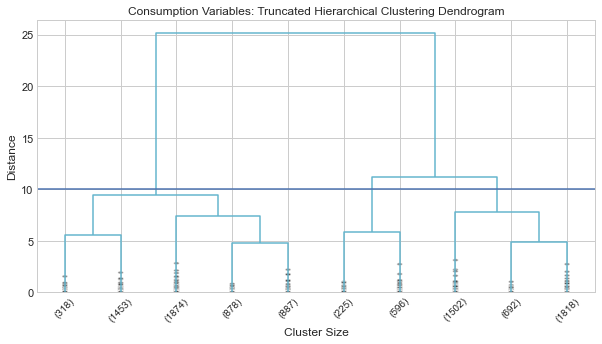

In [47]:
#HIERARCHICAL CLUSTERING - to see the optimal number of k

# Selecting data
variables = df_minmaxtp.loc[:,['MonthSal','Children','CustMonVal', 'Total_Premiums']]

#Ploting the dendrogram
plt.figure(figsize=(10,5))
plt.style.use('seaborn-whitegrid')

Z = linkage(df_metric, method ='ward')



hierarchy.set_link_color_palette(['c', 'm', 'y', 'g','b','r','k']) 
 
dendrogram(Z,
           truncate_mode='lastp',
           p=10,
           orientation = 'top',
           leaf_rotation=45.,
           leaf_font_size=10.,
           show_contracted=True,
           show_leaf_counts=True, color_threshold=75, above_threshold_color='k')
plt.title('Consumption Variables: Truncated Hierarchical Clustering Dendrogram')
plt.xlabel('Cluster Size')
plt.ylabel('Distance')
plt.axhline(y=10)
plt.show()

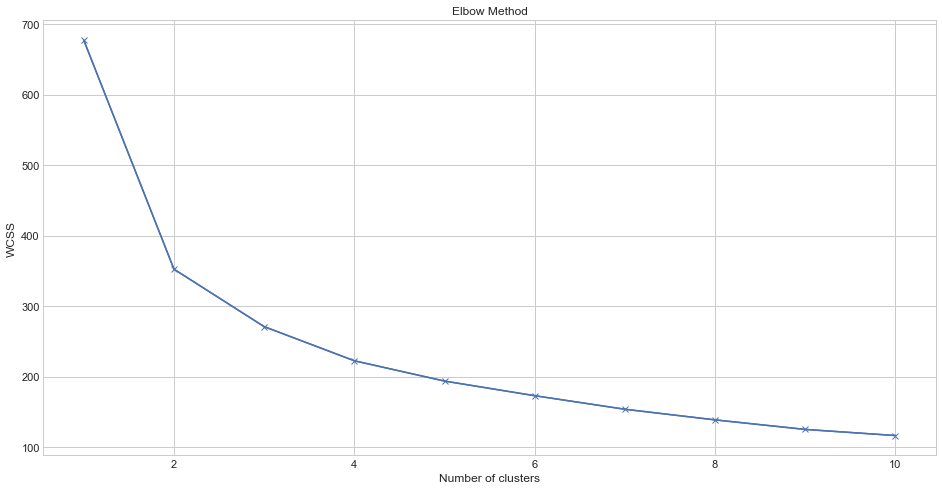

In [48]:
#Using the elbow method as well to help determine the optimal number of K
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=1500,n_init=100, random_state=0)
    kmeans.fit(df_metric)
    wcss.append(kmeans.inertia_)
    
plt.figure(figsize=(16,8))
plt.plot(range(1, 11), wcss)
plt.title('The elbow method for optimal K')
plt.plot(range(1, 11), wcss,'bx-')
plt.grid
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [49]:
#Computing the optimal number of K programatically 
kl = KeeeLocator(range(1, 11), wcss, curve="convex", direction="decreasing")

kl.elbow

3

In [50]:
#Applying kmeans for the optimal number of K and adding the cluster labels to the df 

kmeans= KMeans(n_clusters=3, init='k-means++', max_iter=1000000,n_init=30, random_state=0)
label=kmeans.fit_predict(df_metric)


df_minmaxtp['label']=label
df_minmaxtp

CustID  FirstPolYear  BirthYear  MonthSal  Children  CustMonVal  \
0          1.0        1985.0     1982.0  0.393345       1.0    0.322851   
1          2.0        1995.0     1981.0  0.073379       1.0    0.115590   
2          3.0        1991.0     1970.0  0.414676       0.0    0.372916   
3          4.0        1990.0     1981.0  0.163396       1.0    0.161786   
4          5.0        1986.0     1973.0  0.305034       1.0    0.182921   
...        ...           ...        ...       ...       ...         ...   
10291  10292.0        1984.0     1949.0  0.609002       0.0    0.168617   
10292  10293.0        1977.0     1952.0  0.447526       0.0    0.737547   
10293  10294.0        1994.0     1976.0  0.551408       1.0    0.380780   
10294  10295.0        1981.0     1977.0  0.349403       1.0    0.269864   
10295  10296.0        1990.0     1981.0  0.529437       1.0    0.356354   

       Total_Premiums  b'1 - Basic'  b'2 - High School'  b'3 - BSc/MSc'  \
0            0.174675             0                   1               0   
1            0.311845             0                   1               0   
2            0.216620             1                   0               0   
3            0.138409             0                   0               1   
4            0.154373             0                   0               1   
...               ...           ...                 ...             ...   
10291        0.161260             0                   0               0   
10292        0.602306             1                   0               0   
10293        0.191824             0                   0               1   
10294        0.235803             1                   0               0   
10295        0.176911             0                   0               0   

       b'4 - PhD'  Geo1  Geo2  Geo3  Geo4  label  
0               0     1     0     0     0      2  
1               0     0     0     0     1      1  
2               0     0     0     1     0      2  
3               0     0     0     0     1      1  
4               0     0     0     0     1      2  
...           ...   ...   ...   ...   ...    ...  
10291           1     0     1     0     0      0  
10292           0     0     0     1     0      1  
10293           0     1     0     0     0      0  
10294           0     0     1     0     0      2  
10295           1     1     0     0     0      2  

[10243 rows x 16 columns]

In [51]:
df_minmaxtp.groupby('label').mean() #clusters are hard to distinguish 

CustID  FirstPolYear    BirthYear  MonthSal  Children  CustMonVal  \
label                                                                           
0      5116.196677   1986.211683  1950.160504  0.688349  0.405145    0.254623   
1      5231.667745   1991.677445  1983.472110  0.195379  0.838319    0.283529   
2      5138.166956   1986.509537  1971.068615  0.417327  0.907357    0.243157   

       Total_Premiums  b'1 - Basic'  b'2 - High School'  b'3 - BSc/MSc'  \
label                                                                     
0            0.220560      0.086013            0.346463        0.495713   
1            0.310596      0.258286            0.380760        0.328213   
2            0.174589      0.073322            0.311618        0.529106   

       b'4 - PhD'      Geo1      Geo2      Geo3      Geo4  
label                                                      
0        0.071811  0.281618  0.107181  0.193730  0.417471  
1        0.032741  0.300323  0.087712  0.200889  0.411075  
2        0.085955  0.307159  0.103047  0.205351  0.384444

In [53]:
df_metric2=df_minmax[['MonthSal','CustMonVal','PremMotor','PremHousehold','PremHealth','PremLife','PremWork']]
df_metric2 #defining a dataframe with metric features including all the premiums to be used later

MonthSal  CustMonVal  PremMotor  PremHousehold  PremHealth  PremLife  \
0      0.393345    0.322851   0.644732       0.075986    0.333663  0.185213   
1      0.073379    0.115590   0.138411       0.241661    0.266984  0.690923   
2      0.414676    0.372916   0.356778       0.147348    0.284716  0.320119   
3      0.163396    0.161786   0.316614       0.058226    0.704047  0.145194   
4      0.305034    0.182921   0.581559       0.060415    0.415084  0.088406   
...         ...         ...        ...            ...         ...       ...   
10291  0.609002    0.168617   0.675089       0.061227    0.395352  0.057543   
10292  0.447526    0.737547   0.233638       0.546468    0.326674  0.068208   
10293  0.551408    0.380780   0.691870       0.102234    0.324426  0.067453   
10294  0.349403    0.269864   0.326981       0.140780    0.450547  0.243133   
10295  0.529437    0.356354   0.709602       0.083366    0.322179  0.047632   

       PremWork  
0      0.079112  
1      0.323484  
2      0.304014  
3      0.110466  
4      0.146366  
...         ...  
10291  0.073334  
10292  0.320746  
10293  0.046251  
10294  0.342050  
10295  0.068158  

[10188 rows x 7 columns]

## Hierarquical and Inertia + kmeans (with all premiums)

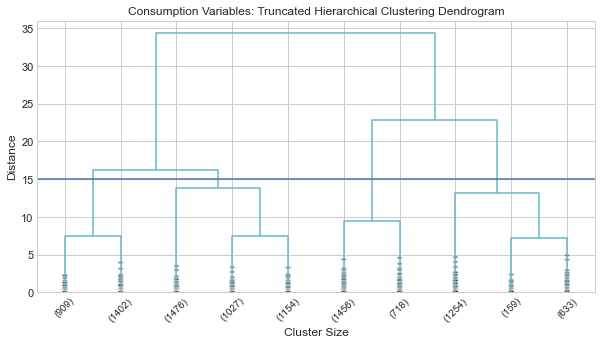

In [54]:
#HIERARCHICAL CLUSTERING - to see the optimal number of k

# Selecting data
variables = df_minmax.loc[:,['MonthSal','CustMonVal','PremMotor','PremHousehold','PremHealth','PremLife','PremWork']]


#Ploting the dendrogram
plt.figure(figsize=(10,5))
plt.style.use('seaborn-whitegrid')

Z = linkage(df_metric2, method ='ward')


hierarchy.set_link_color_palette(['c', 'm', 'y', 'g','b','r','k']) 
 
dendrogram(Z,
           truncate_mode='lastp',
           p=10,
           orientation = 'top',
           leaf_rotation=45.,
           leaf_font_size=10.,
           show_contracted=True,
           show_leaf_counts=True, color_threshold=75, above_threshold_color='k')
plt.title('Consumption Variables: Truncated Hierarchical Clustering Dendrogram')
plt.xlabel('Cluster Size')
plt.ylabel('Distance')
plt.axhline(y=15)
plt.show()

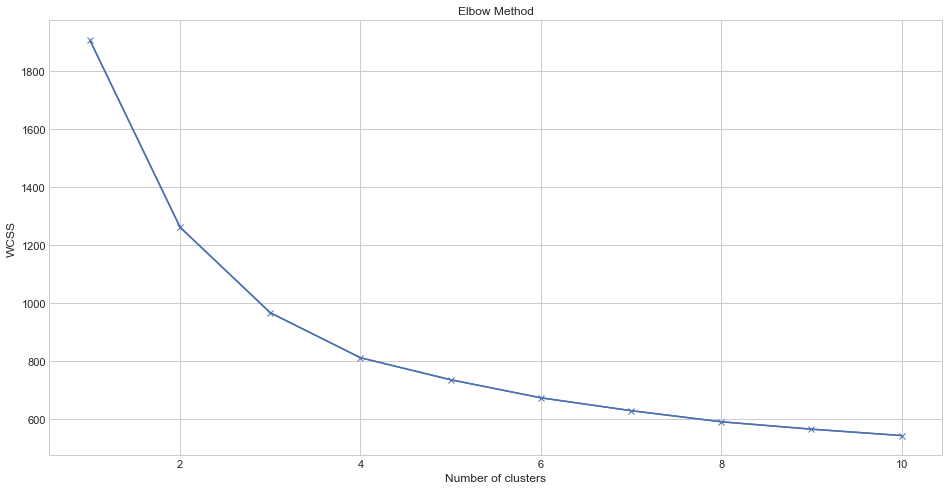

In [55]:
#Using the elbow method to determine the optimal number of K
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=1500,n_init=100,random_state=0)
    kmeans.fit(df_metric2)
    wcss.append(kmeans.inertia_)
    
plt.figure(figsize=(16,8))
plt.plot(range(1, 11), wcss)
plt.title('The elbow method for optimal K')
plt.plot(range(1, 11), wcss,'bx-')
plt.grid
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [56]:
kl = KneeLocator(range(1, 11), wcss, curve="convex", direction="decreasing")

kl.elbow

4

In [57]:
kmeans= KMeans(n_clusters=4, init='k-means++', max_iter=1000000,n_init=30,random_state=0)
label=kmeans.fit_predict(df_metric2)

df_hikmeans=df_minmax.copy()

df_hikmeans['label']=label
df_hikmeans.groupby('label').mean()   #Seems to be a good solution

CustID  FirstPolYear    BirthYear  MonthSal  Children  CustMonVal  \
label                                                                           
0      5138.979028   1986.259350  1949.310031  0.689626  0.320867    0.251918   
1      5117.218818   1986.197126  1965.496204  0.486848  0.867408    0.254561   
2      5101.914434   1988.289542  1979.503457  0.293448  0.913137    0.245495   
3      5355.241509   1993.442264  1983.173585  0.202665  0.744906    0.289627   

       PremMotor  PremHousehold  PremHealth  PremLife  PremWork  b'1 - Basic'  \
label                                                                           
0       0.414928       0.151333    0.479781  0.180207  0.155546      0.097868   
1       0.760323       0.071039    0.237537  0.072270  0.070583      0.042299   
2       0.439233       0.133182    0.498568  0.146306  0.140975      0.087727   
3       0.170739       0.294872    0.378065  0.419345  0.325376      0.438491   

       b'2 - High School'  b'3 - BSc/MSc'  b'4 - PhD'      Geo1      Geo2  \
label                                                                       
0                0.396015        0.459979    0.046138  0.279972  0.104509   
1                0.242679        0.595174    0.119848  0.302603  0.104121   
2                0.380294        0.480553    0.051426  0.302506  0.100691   
3                0.429434        0.129811    0.002264  0.299623  0.085283   

           Geo3      Geo4  
label                      
0      0.192240  0.423279  
1      0.206074  0.387202  
2      0.200519  0.396283  
3      0.198491  0.416604

## Hierarquical + Hierarquical 

In [58]:
df_hier=df_minmax.copy()

In [59]:
def get_r2_hc(df, link_method, max_nclus, min_nclus=1, dist="euclidean"):
    """This function computes the R2 for a set of cluster solutions given by the application of a hierarchical method.
    The R2 is a measure of the homogenity of a cluster solution. It is based on SSt = SSw + SSb and R2 = SSb/SSt. 
    
    Parameters:
    df (DataFrame): Dataset to apply clustering
    link_method (str): either "ward", "complete", "average", "single"
    max_nclus (int): maximum number of clusters to compare the methods
    min_nclus (int): minimum number of clusters to compare the methods. Defaults to 1.
    dist (str): distance to use to compute the clustering solution. Must be a valid distance. Defaults to "euclidean".
    
    Returns:
    ndarray: R2 values for the range of cluster solutions
    """
    def get_ss(df):
        ss = np.sum(df.var() * (df.count() - 1))
        return ss  
    
    sst = get_ss(df)  
    
    r2 = []  
    
    for i in range(min_nclus, max_nclus+1):  
        cluster = AgglomerativeClustering(n_clusters=i, affinity=dist, linkage=link_method)
        
        
        hclabels = cluster.fit_predict(df) 
        
        
        df_concat = pd.concat((df, pd.Series(hclabels, name='labels')), axis=1)  
        
        
        ssw_labels = df_concat.groupby(by='labels').apply(get_ss)  
        
        
        ssb = sst - np.sum(ssw_labels) 
        
        
        r2.append(ssb / sst)  
        
    return np.array(r2)

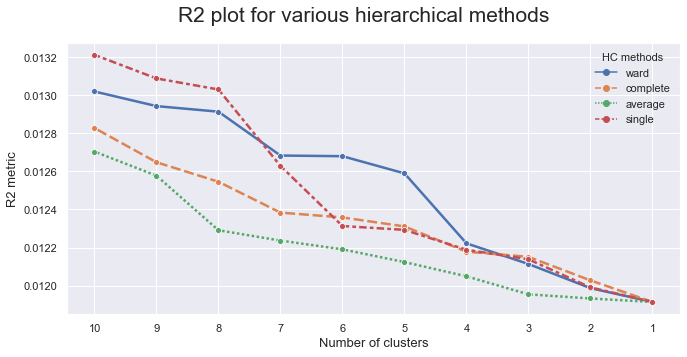

In [60]:

# Preparing the input
hc_methods = ["ward", "complete", "average", "single"]
# Call function defined above to obtain the R2 statistic for each hc_method
max_nclus = 10
r2_hc_methods = np.vstack(
    [
        get_r2_hc(df=df_metric2, link_method=link, max_nclus=max_nclus) 
        for link in hc_methods
    ]
).T
r2_hc_methods = pd.DataFrame(r2_hc_methods, index=range(1, max_nclus + 1), columns=hc_methods)

sns.set()
# Plot data
fig = plt.figure(figsize=(11,5))
sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)


fig.suptitle("R2 plot for various hierarchical methods", fontsize=21)
plt.gca().invert_xaxis()  
plt.legend(title="HC methods", title_fontsize=11)
plt.xticks(range(1, max_nclus + 1))
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2 metric", fontsize=13)

plt.show()

In [61]:
# setting distance_threshold=0 and n_clusters=None to compute the full tree
linkage = 'ward'
distance = 'euclidean'
hclust = AgglomerativeClustering(linkage=linkage, affinity=distance, distance_threshold=0, n_clusters=None)
hclust.fit_predict(df_metric2)

array([8341, 9549, 6230, ...,    4,    1,    0], dtype=int64)

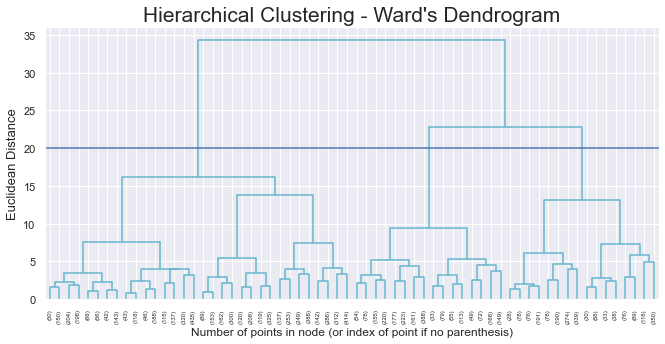

In [62]:
# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

for i, merge in enumerate(hclust.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1  
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count


linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters tuning
y_threshold = 100
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.axhline(y=20)
plt.show()

In [63]:
linkage = 'ward'
distance = 'euclidean'
hc4lust = AgglomerativeClustering(linkage=linkage, affinity=distance, n_clusters=3)
hc4_labels = hc4lust.fit_predict(df_metric2)

df_concat = pd.concat((df_hier, pd.Series(hc4_labels, name='labels')), axis=1)
df_concat.groupby('labels').mean()  #not conclusive/homogeneous clusters

CustID  FirstPolYear    BirthYear  MonthSal  Children  \
labels                                                               
0.0     5048.788253   1987.645565  1966.686696  0.460602  0.711747   
1.0     5246.015834   1987.691242  1966.157348  0.465360  0.710045   
2.0     5085.921897   1987.530916  1965.922827  0.468357  0.695955   

        CustMonVal  PremMotor  PremHousehold  PremHealth  PremLife  PremWork  \
labels                                                                         
0.0       0.254904   0.513931       0.137039    0.382293  0.164385  0.143794   
1.0       0.257889   0.509221       0.140381    0.384394  0.162586  0.147587   
2.0       0.257629   0.517691       0.131893    0.385452  0.165581  0.139294   

        b'1 - Basic'  b'2 - High School'  b'3 - BSc/MSc'  b'4 - PhD'  \
labels                                                                 
0.0         0.119499            0.343602        0.466317    0.070582   
1.0         0.130134            0.334488        0.471549    0.063830   
2.0         0.109252            0.337982        0.485356    0.067411   

            Geo1      Geo2      Geo3      Geo4  
labels                                          
0.0     0.293162  0.095972  0.199052  0.411814  
1.0     0.295893  0.108857  0.205344  0.389906  
2.0     0.301255  0.107857  0.197118  0.393770

## KMEANS + hierarchical

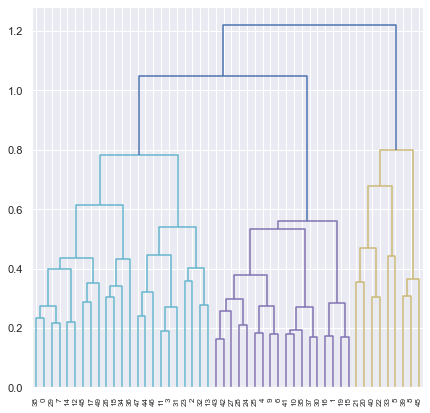

In [64]:
kmeans= KMeans(n_clusters=50, init='k-means++', max_iter=1000000,n_init=30, random_state=0)
label=kmeans.fit_predict(df_metric2)
centroids=kmeans.cluster_centers_

Z = hierarchy.linkage(centroids, method = "complete")

plt.figure(figsize=(7,7))
dendrogram(Z, orientation='top',distance_sort='descending',show_leaf_counts=True)
plt.show()

In [126]:
hc4lust = AgglomerativeClustering(linkage='complete', affinity='euclidean', n_clusters=3) #trying 3 clusters
hc4_labels = hc4lust.fit_predict(df_metric2)

df_kmeansh=df_minmax.copy()

df_kmeansh['label']=hc4_labels
df_kmeansh.groupby('label').mean() 

CustID  FirstPolYear    BirthYear  MonthSal  Children  CustMonVal  \
label                                                                           
0      5420.359551   1994.531461  1985.157303  0.167173  0.737079    0.310040   
1      5134.098584   1987.895271  1963.829014  0.492966  0.552498    0.247276   
2      5118.883168   1986.349415  1965.184518  0.490032  0.808821    0.253808   

       PremMotor  PremHousehold  PremHealth  PremLife  PremWork  b'1 - Basic'  \
label                                                                           
0       0.156712       0.330170    0.341279  0.409074  0.362628      0.516854   
1       0.341551       0.168695    0.520783  0.215828  0.176480      0.133048   
2       0.686929       0.084351    0.297080  0.090795  0.086294      0.047165   

       b'2 - High School'  b'3 - BSc/MSc'  b'4 - PhD'      Geo1      Geo2  \
label                                                                       
0                0.366292        0.115730    0.001124  0.304494  0.089888   
1                0.443762        0.391397    0.031793  0.292813  0.099386   
2                0.268227        0.580918    0.103690  0.296490  0.103870   

           Geo3      Geo4  
label                      
0      0.202247  0.403371  
1      0.194229  0.413572  
2      0.203420  0.396220

In [66]:
hc4lust = AgglomerativeClustering(linkage='complete', affinity='euclidean', n_clusters=4) #trying 4 clusters
hc4_labels = hc4lust.fit_predict(df_metric2)
df_kmeansh['label']=hc4_labels
df_kmeansh.groupby('label').mean() 

CustID  FirstPolYear    BirthYear  MonthSal  Children  CustMonVal  \
label                                                                           
0      5134.098584   1987.895271  1963.829014  0.492966  0.552498    0.247276   
1      5373.930818   1993.788260  1984.719078  0.173700  0.763103    0.308869   
2      5118.883168   1986.349415  1965.184518  0.490032  0.808821    0.253808   
3      5473.983051   1995.389831  1985.663438  0.159635  0.707022    0.311393   

       PremMotor  PremHousehold  PremHealth  PremLife  PremWork  b'1 - Basic'  \
label                                                                           
0       0.341551       0.168695    0.520783  0.215828  0.176480      0.133048   
1       0.186090       0.344723    0.370366  0.234724  0.403608      0.442348   
2       0.686929       0.084351    0.297080  0.090795  0.086294      0.047165   
3       0.122782       0.313363    0.307685  0.610443  0.315297      0.602906   

       b'2 - High School'  b'3 - BSc/MSc'  b'4 - PhD'      Geo1      Geo2  \
label                                                                       
0                0.443762        0.391397    0.031793  0.292813  0.099386   
1                0.400419        0.155136    0.002096  0.345912  0.083857   
2                0.268227        0.580918    0.103690  0.296490  0.103870   
3                0.326877        0.070218    0.000000  0.256659  0.096852   

           Geo3      Geo4  
label                      
0      0.194229  0.413572  
1      0.205451  0.364780  
2      0.203420  0.396220  
3      0.198547  0.447942

In [67]:
metric_features=['MonthSal','CustMonVal','PremMotor','PremHousehold','PremHealth','PremLife','PremWork']

## self organizing maps + kmeans

In [68]:
import sompy
from sompy.visualization.mapview import View2D
from sompy.visualization.bmuhits import BmuHitsView
from sompy.visualization.hitmap import HitMapView

In [69]:
df_somk=df_minmax.copy()

In [70]:
np.random.seed(42)

#Trainning SOM
sm = sompy.SOMFactory().build(
    df_metric2.values, 
    mapsize=[50,50], 
    initialization='random',
    neighborhood='gaussian',
    training='batch',
    lattice='hexa',
    component_names=metric_features
)
sm.train(n_job=-1, verbose='info', train_rough_len=100, train_finetune_len=100)

sm.codebook.matrix

 Training...
 random_initialization took: 0.002000 seconds
 Rough training...
 radius_ini: 17.000000 , radius_final: 2.833333, trainlen: 100

 epoch: 1 ---> elapsed time:  0.482000, quantization error: 1.504035

 epoch: 2 ---> elapsed time:  0.511000, quantization error: 2.419851

 epoch: 3 ---> elapsed time:  0.520000, quantization error: 2.376541

 epoch: 4 ---> elapsed time:  0.517000, quantization error: 2.366314

 epoch: 5 ---> elapsed time:  0.524000, quantization error: 2.363042

 epoch: 6 ---> elapsed time:  0.529000, quantization error: 2.361307

 epoch: 7 ---> elapsed time:  0.523000, quantization error: 2.359889

 epoch: 8 ---> elapsed time:  0.513000, quantization error: 2.358537

 epoch: 9 ---> elapsed time:  0.527000, quantization error: 2.357191

 epoch: 10 ---> elapsed time:  0.514000, quantization error: 2.355828

 epoch: 11 ---> elapsed time:  0.514000, quantization error: 2.354437

 epoch: 12 ---> elapsed time:  0.519000, quantization error: 2.353016

 epoch: 13 --->

 epoch: 14 ---> elapsed time:  0.556000, quantization error: 1.673467

 epoch: 15 ---> elapsed time:  0.511000, quantization error: 1.666601

 epoch: 16 ---> elapsed time:  0.515000, quantization error: 1.659669

 epoch: 17 ---> elapsed time:  0.500000, quantization error: 1.652584

 epoch: 18 ---> elapsed time:  0.491000, quantization error: 1.645307

 epoch: 19 ---> elapsed time:  0.502000, quantization error: 1.638018

 epoch: 20 ---> elapsed time:  0.509000, quantization error: 1.630684

 epoch: 21 ---> elapsed time:  0.503000, quantization error: 1.623237

 epoch: 22 ---> elapsed time:  0.516000, quantization error: 1.615856

 epoch: 23 ---> elapsed time:  0.501000, quantization error: 1.608364

 epoch: 24 ---> elapsed time:  0.504000, quantization error: 1.600925

 epoch: 25 ---> elapsed time:  0.489000, quantization error: 1.593208

 epoch: 26 ---> elapsed time:  0.504000, quantization error: 1.585496

 epoch: 27 ---> elapsed time:  0.520000, quantization error: 1.577827

 epoch

array([[ 1.354914e+00, -7.444780e-01, -1.021865e+00, ...,  1.526784e+00,
         1.185290e-01, -1.244640e-01],
       [ 1.356373e+00, -7.828240e-01, -1.006782e+00, ...,  1.612278e+00,
        -4.815300e-02,  9.596500e-02],
       [ 1.360807e+00, -7.837470e-01, -1.023330e+00, ...,  1.762954e+00,
        -1.917190e-01,  2.903950e-01],
       ...,
       [-8.016180e-01,  4.557950e-01, -3.860000e-04, ...,  6.461420e-01,
        -5.021340e-01, -4.640240e-01],
       [-8.628670e-01,  6.694460e-01,  2.507600e-02, ...,  7.254380e-01,
        -5.572440e-01, -4.628500e-01],
       [-8.513720e-01,  5.933780e-01,  8.703300e-02, ...,  7.866820e-01,
        -6.141900e-01, -5.289120e-01]])

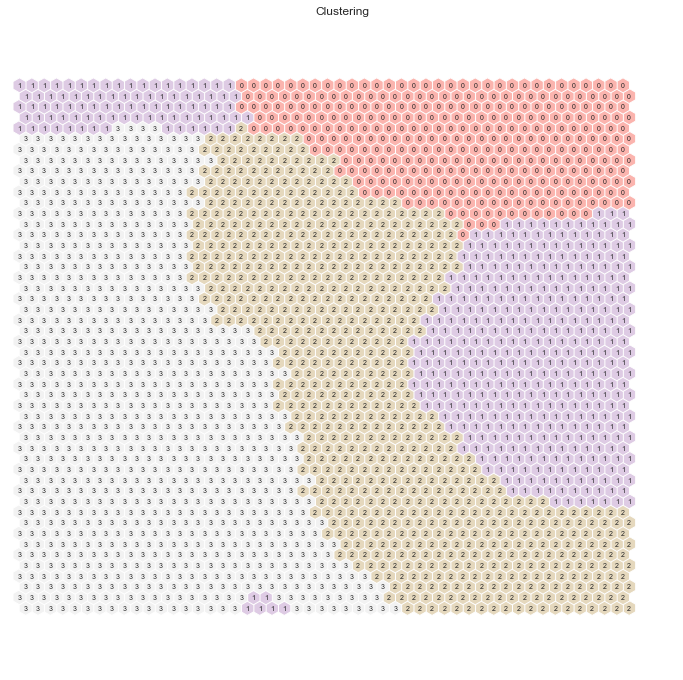

In [71]:
kmeans2 = KMeans(n_clusters=4, init='k-means++', n_init=20, random_state=0) #elbow method above 

nodeclus_labels = kmeans2.fit_predict(sm.codebook.matrix)
sm.cluster_labels = nodeclus_labels  # setting the cluster labels of sompy


hits = HitMapView(12, 12,"Clustering", text_size=10)
hits.show(sm, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")

plt.show()

In [72]:
nodes = sm.codebook.matrix

df_nodes = pd.DataFrame(nodes, columns=metric_features)
df_nodes['label'] = nodeclus_labels

In [73]:
# Obtaining SOM's BMUs labels
bmus_map = sm.find_bmu(df_somk[metric_features])[0]  # get bmus for each observation in df

df_bmus = pd.DataFrame(
    np.concatenate((df_somk, np.expand_dims(bmus_map,1)), axis=1),
    index=df_somk.index, columns=np.append(df_somk.columns,"BMU")
)

In [74]:
df_somk = df_bmus.merge(df_nodes['label'], 'left', left_on="BMU", right_index=True)

df_somk.drop(columns='BMU').groupby('label').mean() #seems to be a good solution

CustID  FirstPolYear    BirthYear  MonthSal  Children  CustMonVal  \
label                                                                           
1      4643.739130   1995.934783  1985.043478  0.059685  0.673913    0.159575   
2      5167.889314   1988.122458  1964.580187  0.487529  0.600214    0.252787   
3      5126.262427   1986.635379  1969.555957  0.423330  0.905304    0.263974   

       PremMotor  PremHousehold  PremHealth  PremLife  PremWork  b'1 - Basic'  \
label                                                                           
1       0.108554       0.222519    0.292098  0.552605  0.495152      0.717391   
2       0.393630       0.166898    0.458697  0.207546  0.176700      0.154869   
3       0.737036       0.081069    0.247025  0.081452  0.078893      0.048320   

       b'2 - High School'  b'3 - BSc/MSc'  b'4 - PhD'      Geo1      Geo2  \
label                                                                       
1                0.217391        0.065217    0.000000  0.326087  0.043478   
2                0.388320        0.410946    0.045865  0.295826  0.101208   
3                0.257428        0.584282    0.109969  0.295473  0.101361   

           Geo3      Geo4  
label                      
1      0.152174  0.478261  
2      0.195536  0.407430  
3      0.208553  0.394613

## Hierarquical + SOM

In [75]:
df_somkhh=df_minmax.copy()

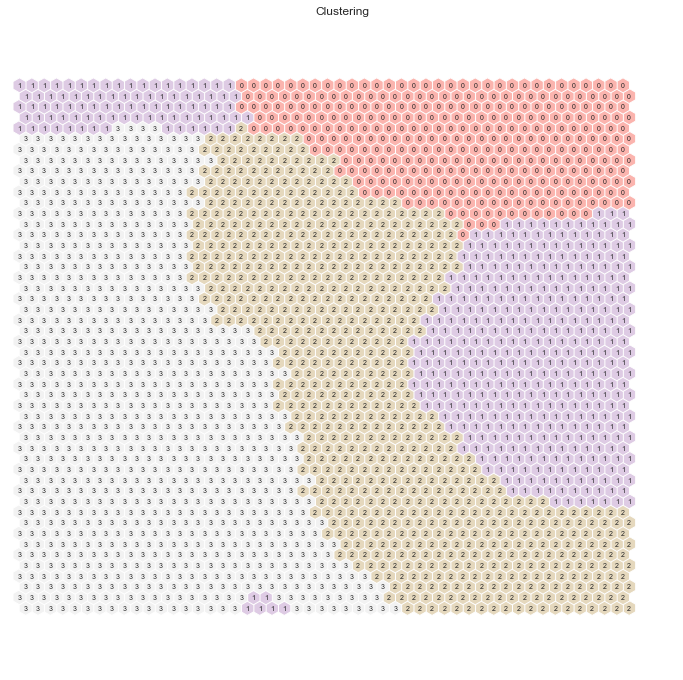

In [76]:
hierclust2 = AgglomerativeClustering(n_clusters=4, linkage='ward')
nodeclus_labels2 = hierclust2.fit_predict(sm.codebook.matrix)
sm.cluster_labels2 = nodeclus_labels2  # setting the cluster labels of sompy

hits2  = HitMapView(12, 12,"Clustering",text_size=10)
hits2.show(sm, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")

plt.show()

In [77]:
nodes2 = sm.codebook.matrix

df_nodes2 = pd.DataFrame(nodes2, columns=metric_features)
df_nodes2['label'] = nodeclus_labels2

bmus_map2 = sm.find_bmu(df_somkhh[metric_features])[0]  # get bmus for each observation in df

df_bmus2 = pd.DataFrame(
    np.concatenate((df_somkhh, np.expand_dims(bmus_map,1)), axis=1),
    index=df_somkhh.index, columns=np.append(df_somkhh.columns,"BMU")
)

In [78]:
df_somkhh = df_bmus2.merge(df_nodes2['label'], 'left', left_on="BMU", right_index=True)

df_somkhh.drop(columns=['BMU']).groupby('label').mean() #seems to be a good solution

CustID  FirstPolYear    BirthYear  MonthSal  Children  CustMonVal  \
label                                                                           
0      5147.900350   1987.262443  1965.194736  0.484361  0.704765    0.256708   
1      5749.490385   1994.019231  1981.250000  0.199653  0.673077    0.591492   
2      5098.086233   1991.897126  1981.727685  0.198474  0.765507    0.198054   

       PremMotor  PremHousehold  PremHealth  PremLife  PremWork  b'1 - Basic'  \
label                                                                           
0       0.537661       0.128609    0.372885  0.153233  0.135586      0.104319   
1       0.156700       0.507486    0.302316  0.266438  0.328930      0.625000   
2       0.228621       0.195429    0.541864  0.309623  0.228183      0.260212   

       b'2 - High School'  b'3 - BSc/MSc'  b'4 - PhD'      Geo1      Geo2  \
label                                                                       
0                0.334819        0.487955    0.072907  0.295447  0.101772   
1                0.288462        0.086538    0.000000  0.278846  0.086538   
2                0.441755        0.284418    0.013616  0.304085  0.092284   

           Geo3      Geo4  
label                      
0      0.201953  0.400828  
1      0.192308  0.442308  
2      0.172466  0.431165

## DBSCAN and Mean-shift

In [79]:
df_dbscan=df_minmax.copy()

dbscan = DBSCAN(eps=0.0423, min_samples=14, n_jobs=-1)  
dbscan_labels = dbscan.fit_predict(df_metric2)

dbscan_n_clusters = len(np.unique(dbscan_labels))
print("Number of estimated clusters : %d" % dbscan_n_clusters)
df_dbscan['label']=dbscan_labels
df_dbscan.groupby('label').mean() # clusters are too homogeneous 

Number of estimated clusters : 5


CustID  FirstPolYear    BirthYear  MonthSal  Children  CustMonVal  \
label                                                                           
-1     5150.579337   1987.636373  1966.429051  0.463022  0.707421    0.256338   
 0     5387.071429   1984.928571  1965.857143  0.454915  1.000000    0.148160   
 1     4523.642857   1987.857143  1966.428571  0.432761  0.785714    0.360161   
 2     6022.928571   1989.714286  1967.785714  0.447755  0.857143    0.156853   
 3     4783.750000   1984.500000  1967.416667  0.427439  0.916667    0.362210   

       PremMotor  PremHousehold  PremHealth  PremLife  PremWork  b'1 - Basic'  \
label                                                                           
-1      0.511842       0.137318    0.384329  0.165185  0.144079      0.120387   
 0      0.915454       0.028173    0.107123  0.039956  0.049553      0.000000   
 1      0.869159       0.040414    0.160033  0.040338  0.035558      0.000000   
 2      0.851393       0.047580    0.175715  0.038623  0.051771      0.000000   
 3      0.823844       0.052892    0.193554  0.053316  0.054366      0.000000   

       b'2 - High School'  b'3 - BSc/MSc'  b'4 - PhD'      Geo1      Geo2  \
label                                                                       
-1               0.342313        0.469509    0.067792  0.296132  0.100651   
 0               0.142857        0.500000    0.357143  0.214286  0.071429   
 1               0.142857        0.785714    0.071429  0.285714  0.142857   
 2               0.000000        0.857143    0.142857  0.142857  0.285714   
 3               0.333333        0.583333    0.083333  0.333333  0.166667   

           Geo3      Geo4  
label                      
-1     0.200217  0.403000  
 0     0.214286  0.500000  
 1     0.071429  0.500000  
 2     0.285714  0.285714  
 3     0.000000  0.500000

In [80]:
#Mean Shift Clustering - Not useful for the analysis

#df_clustms=df_minmax.copy()

#bandwidth = estimate_bandwidth(df_metric2, random_state=0, quantile=0.06) 

#ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, n_jobs=4)

#ms_labels = ms.fit_predict(df_metric2)
#ms_n_clusters = len(np.unique(ms_labels))
#print("Number of estimated clusters : %d" % ms_n_clusters)
#df_clustms['label']=ms_labels
#df_clustms.groupby('label').mean()

## GMM Clustering

In [81]:
df_gmm=df_minmax.copy()

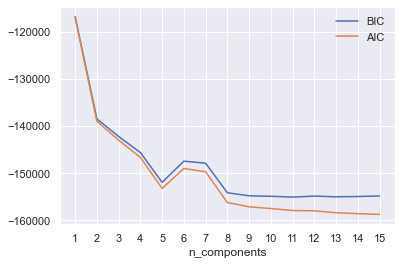

In [82]:
#finding the n of components
n_components = np.arange(1, 16)
models = [GaussianMixture(n, covariance_type='full', n_init=10, random_state=0).fit(df_metric2)
          for n in n_components]

bic_values = [m.bic(df_metric2) for m in models]
aic_values = [m.aic(df_metric2) for m in models]
plt.plot(n_components, bic_values, label='BIC')
plt.plot(n_components, aic_values, label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.xticks(n_components)
plt.show()

In [83]:
gmm = GaussianMixture(n_components=4, covariance_type='full', n_init=10, init_params='kmeans', random_state=0)

gmm_labels = gmm.fit_predict(df_metric2)

labels_proba = gmm.predict_proba(df_metric2)


In [84]:
df_gmm['label']=gmm_labels
df_gmm.groupby('label').mean() #seems to be a good solution

CustID  FirstPolYear    BirthYear  MonthSal  Children  CustMonVal  \
label                                                                           
0      5143.391487   1986.257014  1966.461142  0.476025  0.865527    0.250495   
1      5262.405305   1993.079581  1984.261567  0.195320  0.781616    0.282678   
2      5193.888585   1986.530417  1952.305537  0.652577  0.386876    0.269089   
3      5095.621284   1986.894079  1964.350487  0.491781  0.674494    0.245493   

       PremMotor  PremHousehold  PremHealth  PremLife  PremWork  b'1 - Basic'  \
label                                                                           
0       0.765401       0.059194    0.259864  0.055123  0.058797      0.028055   
1       0.203229       0.277624    0.408983  0.358047  0.302909      0.368291   
2       0.342151       0.212329    0.423581  0.260270  0.212091      0.191388   
3       0.507191       0.112320    0.453363  0.135943  0.119668      0.063952   

       b'2 - High School'  b'3 - BSc/MSc'  b'4 - PhD'      Geo1      Geo2  \
label                                                                       
0                0.211222        0.622702    0.138020  0.293131  0.109965   
1                0.433066        0.193708    0.004935  0.309068  0.088217   
2                0.528366        0.267943    0.012303  0.291866  0.110731   
3                0.336498        0.539096    0.060455  0.294029  0.095678   

           Geo3      Geo4  
label                      
0      0.206063  0.390842  
1      0.202344  0.400370  
2      0.187286  0.410116  
3      0.198851  0.411441

## CLUSTER ANALYSIS (best solutions)

In [127]:
df_kmeansh # kmeans into hiearquical 
df_kmeansh.groupby('label').mean()  

CustID  FirstPolYear    BirthYear  MonthSal  Children  CustMonVal  \
label                                                                           
0      5420.359551   1994.531461  1985.157303  0.167173  0.737079    0.310040   
1      5134.098584   1987.895271  1963.829014  0.492966  0.552498    0.247276   
2      5118.883168   1986.349415  1965.184518  0.490032  0.808821    0.253808   

       PremMotor  PremHousehold  PremHealth  PremLife  PremWork  b'1 - Basic'  \
label                                                                           
0       0.156712       0.330170    0.341279  0.409074  0.362628      0.516854   
1       0.341551       0.168695    0.520783  0.215828  0.176480      0.133048   
2       0.686929       0.084351    0.297080  0.090795  0.086294      0.047165   

       b'2 - High School'  b'3 - BSc/MSc'  b'4 - PhD'      Geo1      Geo2  \
label                                                                       
0                0.366292        0.115730    0.001124  0.304494  0.089888   
1                0.443762        0.391397    0.031793  0.292813  0.099386   
2                0.268227        0.580918    0.103690  0.296490  0.103870   

           Geo3      Geo4  
label                      
0      0.202247  0.403371  
1      0.194229  0.413572  
2      0.203420  0.396220

In [128]:
df_kmeansh['label'].value_counts()

2    5555
1    3743
0     890
Name: label, dtype: int64

In [87]:
df_hikmeans.groupby('label').mean() #hiearchical + inertia to kmeans

CustID  FirstPolYear    BirthYear  MonthSal  Children  CustMonVal  \
label                                                                           
0      5138.979028   1986.259350  1949.310031  0.689626  0.320867    0.251918   
1      5117.218818   1986.197126  1965.496204  0.486848  0.867408    0.254561   
2      5101.914434   1988.289542  1979.503457  0.293448  0.913137    0.245495   
3      5355.241509   1993.442264  1983.173585  0.202665  0.744906    0.289627   

       PremMotor  PremHousehold  PremHealth  PremLife  PremWork  b'1 - Basic'  \
label                                                                           
0       0.414928       0.151333    0.479781  0.180207  0.155546      0.097868   
1       0.760323       0.071039    0.237537  0.072270  0.070583      0.042299   
2       0.439233       0.133182    0.498568  0.146306  0.140975      0.087727   
3       0.170739       0.294872    0.378065  0.419345  0.325376      0.438491   

       b'2 - High School'  b'3 - BSc/MSc'  b'4 - PhD'      Geo1      Geo2  \
label                                                                       
0                0.396015        0.459979    0.046138  0.279972  0.104509   
1                0.242679        0.595174    0.119848  0.302603  0.104121   
2                0.380294        0.480553    0.051426  0.302506  0.100691   
3                0.429434        0.129811    0.002264  0.299623  0.085283   

           Geo3      Geo4  
label                      
0      0.192240  0.423279  
1      0.206074  0.387202  
2      0.200519  0.396283  
3      0.198491  0.416604

In [88]:
df_hikmeans['label'].value_counts()

1    3688
0    2861
2    2314
3    1325
Name: label, dtype: int64

In [89]:
df_somk.groupby('label').mean()  #som + kmeans

CustID  FirstPolYear    BirthYear  MonthSal  Children  CustMonVal  \
label                                                                           
1      4643.739130   1995.934783  1985.043478  0.059685  0.673913    0.159575   
2      5167.889314   1988.122458  1964.580187  0.487529  0.600214    0.252787   
3      5126.262427   1986.635379  1969.555957  0.423330  0.905304    0.263974   

       PremMotor  PremHousehold  PremHealth  PremLife  PremWork  b'1 - Basic'  \
label                                                                           
1       0.108554       0.222519    0.292098  0.552605  0.495152      0.717391   
2       0.393630       0.166898    0.458697  0.207546  0.176700      0.154869   
3       0.737036       0.081069    0.247025  0.081452  0.078893      0.048320   

       b'2 - High School'  b'3 - BSc/MSc'  b'4 - PhD'      Geo1      Geo2  \
label                                                                       
1                0.217391        0.065217    0.000000  0.326087  0.043478   
2                0.388320        0.410946    0.045865  0.295826  0.101208   
3                0.257428        0.584282    0.109969  0.295473  0.101361   

           Geo3      Geo4          BMU  
label                                   
1      0.152174  0.478261  1213.500000  
2      0.195536  0.407430  1477.471488  
3      0.208553  0.394613  1481.364066

In [90]:
df_somk['label'].value_counts()

2    6541
3    3601
1      46
Name: label, dtype: int64

In [91]:
df_somkhh.groupby('label').mean() #som + hierarchical 

CustID  FirstPolYear    BirthYear  MonthSal  Children  CustMonVal  \
label                                                                           
0      5147.900350   1987.262443  1965.194736  0.484361  0.704765    0.256708   
1      5749.490385   1994.019231  1981.250000  0.199653  0.673077    0.591492   
2      5098.086233   1991.897126  1981.727685  0.198474  0.765507    0.198054   

       PremMotor  PremHousehold  PremHealth  PremLife  PremWork  b'1 - Basic'  \
label                                                                           
0       0.537661       0.128609    0.372885  0.153233  0.135586      0.104319   
1       0.156700       0.507486    0.302316  0.266438  0.328930      0.625000   
2       0.228621       0.195429    0.541864  0.309623  0.228183      0.260212   

       b'2 - High School'  b'3 - BSc/MSc'  b'4 - PhD'      Geo1      Geo2  \
label                                                                       
0                0.334819        0.487955    0.072907  0.295447  0.101772   
1                0.288462        0.086538    0.000000  0.278846  0.086538   
2                0.441755        0.284418    0.013616  0.304085  0.092284   

           Geo3      Geo4          BMU  
label                                   
0      0.201953  0.400828  1510.810888  
1      0.192308  0.442308  2181.250000  
2      0.172466  0.431165   894.301059

In [92]:
df_somkhh['label'].value_counts()

0    9423
2     661
1     104
Name: label, dtype: int64

In [93]:
df_gmm.groupby('label').mean() #gaussian

CustID  FirstPolYear    BirthYear  MonthSal  Children  CustMonVal  \
label                                                                           
0      5143.391487   1986.257014  1966.461142  0.476025  0.865527    0.250495   
1      5262.405305   1993.079581  1984.261567  0.195320  0.781616    0.282678   
2      5193.888585   1986.530417  1952.305537  0.652577  0.386876    0.269089   
3      5095.621284   1986.894079  1964.350487  0.491781  0.674494    0.245493   

       PremMotor  PremHousehold  PremHealth  PremLife  PremWork  b'1 - Basic'  \
label                                                                           
0       0.765401       0.059194    0.259864  0.055123  0.058797      0.028055   
1       0.203229       0.277624    0.408983  0.358047  0.302909      0.368291   
2       0.342151       0.212329    0.423581  0.260270  0.212091      0.191388   
3       0.507191       0.112320    0.453363  0.135943  0.119668      0.063952   

       b'2 - High School'  b'3 - BSc/MSc'  b'4 - PhD'      Geo1      Geo2  \
label                                                                       
0                0.211222        0.622702    0.138020  0.293131  0.109965   
1                0.433066        0.193708    0.004935  0.309068  0.088217   
2                0.528366        0.267943    0.012303  0.291866  0.110731   
3                0.336498        0.539096    0.060455  0.294029  0.095678   

           Geo3      Geo4  
label                      
0      0.206063  0.390842  
1      0.202344  0.400370  
2      0.187286  0.410116  
3      0.198851  0.411441

In [94]:
df_gmm['label'].value_counts()

3    4003
0    3101
1    1621
2    1463
Name: label, dtype: int64

## Final Cluster Solution 

In [129]:
df_hikmeans.groupby('label').mean() 

CustID  FirstPolYear    BirthYear  MonthSal  Children  CustMonVal  \
label                                                                           
0      5138.979028   1986.259350  1949.310031  0.689626  0.320867    0.251918   
1      5117.218818   1986.197126  1965.496204  0.486848  0.867408    0.254561   
2      5101.914434   1988.289542  1979.503457  0.293448  0.913137    0.245495   
3      5355.241509   1993.442264  1983.173585  0.202665  0.744906    0.289627   

       PremMotor  PremHousehold  PremHealth  PremLife  PremWork  b'1 - Basic'  \
label                                                                           
0       0.414928       0.151333    0.479781  0.180207  0.155546      0.097868   
1       0.760323       0.071039    0.237537  0.072270  0.070583      0.042299   
2       0.439233       0.133182    0.498568  0.146306  0.140975      0.087727   
3       0.170739       0.294872    0.378065  0.419345  0.325376      0.438491   

       b'2 - High School'  b'3 - BSc/MSc'  b'4 - PhD'      Geo1      Geo2  \
label                                                                       
0                0.396015        0.459979    0.046138  0.279972  0.104509   
1                0.242679        0.595174    0.119848  0.302603  0.104121   
2                0.380294        0.480553    0.051426  0.302506  0.100691   
3                0.429434        0.129811    0.002264  0.299623  0.085283   

           Geo3      Geo4  
label                      
0      0.192240  0.423279  
1      0.206074  0.387202  
2      0.200519  0.396283  
3      0.198491  0.416604

In [109]:
df_hikmeans['label'].value_counts()

1    3688
0    2861
2    2314
3    1325
Name: label, dtype: int64

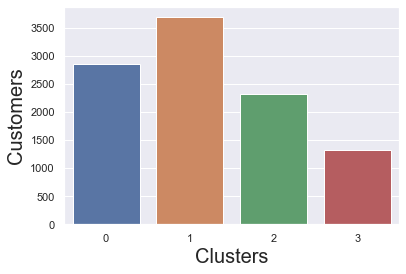

In [110]:
p= sns.countplot(x ='label', data = df_hikmeans) #Ploting number of customers per cluster
p.set_xlabel("Clusters", fontsize = 20)
p.set_ylabel("Customers", fontsize = 20)
    
# Show the plot
plt.show()

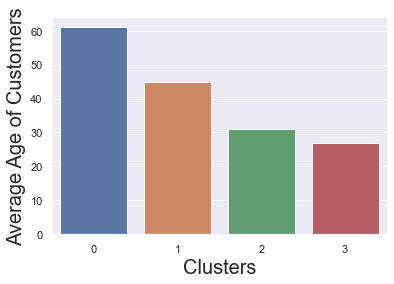

In [124]:
aux = {'Average Age': [61, 45,31,27], 'cluster': [0,1,2,3]} #ploting average age of customers per cluster
df = pd.DataFrame(data=aux)
df
p= sns.barplot(x ='cluster',y='Average Age', data = df)

p.set_xlabel("Clusters", fontsize = 20)
p.set_ylabel("Average Age of Customers", fontsize = 20)
    
# Show the plot
plt.show()

C:\Users\lucas\anaconda3\ANACONDA\envs\Data_Mining\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

C:\Users\lucas\anaconda3\ANACONDA\envs\Data_Mining\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



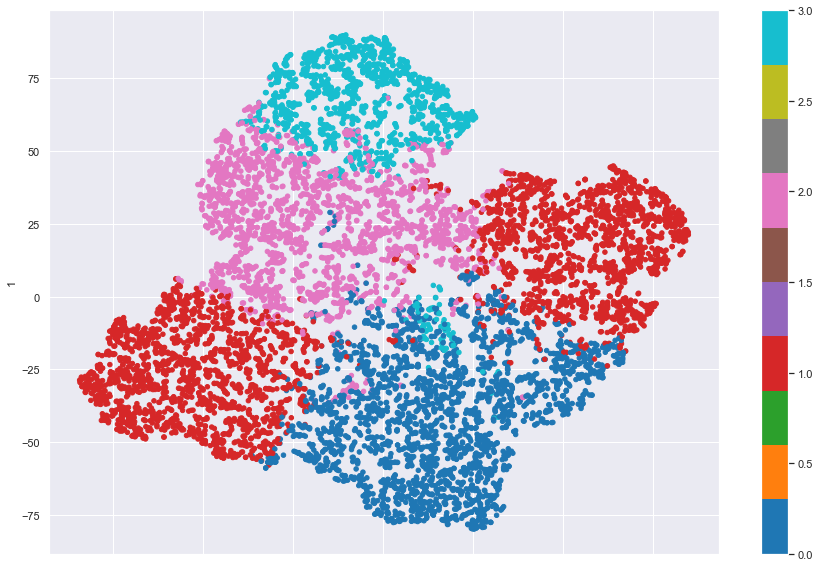

In [111]:
from sklearn.manifold import TSNE #tsne for visualizing the data in 2d
two_dim = TSNE(random_state=42).fit_transform(df_metric2)
pd.DataFrame(two_dim).plot.scatter(x=0, y=1, c=df_hikmeans['label'], colormap='tab10', figsize=(15,10))
plt.show()

In [98]:
non_metric_features = ['CustID','FirstPolYear', 'BirthYear','Children',b'1 - Basic',b'2 - High School',b'3 - BSc/MSc',b'4 - PhD','Geo1','Geo2','Geo3','Geo4']
metric_features = df_minmax.columns.drop(non_metric_features).to_list()

In [112]:
import plotly.express as px #Parallel coordinates plot to visualize the differences in each cluster

fig = px.parallel_coordinates(df_hikmeans, color="label",dimensions=metric_features,
                             color_continuous_scale=px.colors.diverging.Portland, color_continuous_midpoint=2)
fig.show()

## Reintroducing Outliers

In [113]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
import graphviz

In [114]:
# Preparing the data
X = df_hikmeans.drop(columns=['label'])
y = df_hikmeans.label

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Fitting the decision tree
dt = DecisionTreeClassifier(random_state=42, max_depth=3)
dt.fit(X_train, y_train)


C:\Users\lucas\anaconda3\ANACONDA\envs\Data_Mining\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['bytes', 'str']. An error will be raised in 1.2.



DecisionTreeClassifier(max_depth=3, random_state=42)

In [115]:
outliersfinal=pd.concat([df_outliers1,outliers2], ignore_index=True) #df_outliers1 dos primeiros filtros e outliers2 do dbscan

modes=outliersfinal[non_metric_features].mode().loc[0]
means=outliersfinal[metric_features].mean()

outliersfinal.fillna(means, inplace=True)
outliersfinal.fillna(modes, inplace=True)

outliersfinal.isna().sum()
outliersfinal.drop(columns=['EducDeg','ClaimsRate','label','GeoLivArea'],inplace=True)

In [116]:
outliersfinal['label'] = dt.predict(outliersfinal)
outliersfinal

C:\Users\lucas\anaconda3\ANACONDA\envs\Data_Mining\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['bytes', 'str']. An error will be raised in 1.2.



CustID  FirstPolYear  BirthYear     MonthSal  Children     CustMonVal  \
0      52.0        1982.0     1966.0  3234.000000       1.0  -14714.080000   
1     113.0        1997.0     1979.0  2354.000000       1.0   -8719.040000   
2     136.0        1997.0     1988.0  2176.000000       1.0  -10198.910000   
3     150.0        1994.0     1989.0   984.000000       1.0     255.710000   
4     172.0        1990.0     1989.0  1086.000000       1.0 -165680.420000   
..      ...           ...        ...          ...       ...            ...   
101  9236.0        1998.0     1997.0     0.049701       1.0       0.853230   
102  9558.0        2000.0     1988.0     0.101323       0.0       0.730176   
103  9602.0        1980.0     1964.0     0.531143       1.0       0.344123   
104  9813.0        1977.0     1975.0     0.308660       0.0       0.219180   
105  9955.0        1998.0     1974.0     0.092790       1.0       0.000000   

      PremMotor  PremHousehold  PremHealth    PremLife    PremWork  \
0    557.440000      20.000000   29.560000    5.000000   -9.000000   
1    518.320000       4.450000   55.900000    3.890000   10.890000   
2    297.610000     162.800000  143.360000  136.470000   -3.000000   
3     64.900000     197.250000   29.560000   18.560000  451.530000   
4    378.070000      78.900000  166.810000    6.890000   18.450000   
..          ...            ...         ...         ...         ...   
101    0.031680       0.911419    0.115379    0.181784    0.366093   
102    0.045255       0.594042    0.187810    0.795343    0.121721   
103    0.343390       0.115911    0.176821    0.054491    0.745578   
104    0.330002       0.036357    0.207789    0.919207    0.140889   
105    0.043745       0.104152    0.066431    0.633757    0.992990   

     b'1 - Basic'  b'2 - High School'  b'3 - BSc/MSc'  b'4 - PhD'  Geo1  Geo2  \
0             1.0                 0.0             0.0         0.0   0.0   0.0   
1             1.0                 0.0             0.0         0.0   0.0   0.0   
2             1.0                 0.0             0.0         0.0   0.0   0.0   
3             1.0                 0.0             0.0         0.0   0.0   0.0   
4             1.0                 0.0             0.0         0.0   0.0   0.0   
..            ...                 ...             ...         ...   ...   ...   
101           1.0                 0.0             0.0         0.0   0.0   0.0   
102           1.0                 0.0             0.0         0.0   0.0   0.0   
103           0.0                 1.0             0.0         0.0   0.0   0.0   
104           0.0                 0.0             1.0         0.0   1.0   0.0   
105           1.0                 0.0             0.0         0.0   0.0   0.0   

     Geo3  Geo4  label  
0     0.0   0.0      1  
1     0.0   0.0      1  
2     0.0   0.0      1  
3     0.0   0.0      1  
4     0.0   0.0      1  
..    ...   ...    ...  
101   0.0   1.0      3  
102   1.0   0.0      3  
103   1.0   0.0      0  
104   0.0   0.0      2  
105   0.0   1.0      3  

[106 rows x 20 columns]

## Final cluster solution (ratios)

In [104]:
df_racios=df_hikmeans.copy()

df_racios['Total_Premiums'] = df_racios['PremMotor'] + df_racios['PremHousehold'] + df_racios['PremHealth'] + df_racios['PremLife'] + df_racios['PremWork']
df_racios['RatMotor']=df_racios['PremMotor']/(df_racios['Total_Premiums'])
df_racios['RatHouse']=df_racios['PremHousehold']/(df_racios['Total_Premiums'])
df_racios['RatHealth']=df_racios['PremHealth']/(df_racios['Total_Premiums'])
df_racios['RatLife']=df_racios['PremLife']/(df_racios['Total_Premiums'])
df_racios['RatWork']=df_racios['PremWork']/(df_racios['Total_Premiums'])



df_racios.drop(columns=['PremMotor','PremHousehold','PremHealth','PremLife','PremWork','Total_Premiums'],inplace=True)


In [105]:
df_metricrat=df_racios[['MonthSal','CustMonVal',"RatMotor","RatHouse","RatHealth","RatLife","RatWork"]]

In [117]:
kmeans= KMeans(n_clusters=4, init='k-means++', max_iter=1000000,n_init=30)
label=kmeans.fit_predict(df_metricrat)
df_racios['label']=label
df_racios.groupby('label').mean() 

CustID  FirstPolYear    BirthYear  MonthSal  Children  CustMonVal  \
label                                                                           
0      5323.300448   1993.109545  1983.889174  0.196485  0.777707    0.287049   
1      5104.496554   1986.133902  1965.111257  0.493455  0.883820    0.254883   
2      5156.180039   1986.248716  1949.544608  0.686906  0.337933    0.252812   
3      5092.011769   1987.764205  1978.358766  0.310640  0.915990    0.243067   

       b'1 - Basic'  b'2 - High School'  b'3 - BSc/MSc'  b'4 - PhD'      Geo1  \
label                                                                           
0          0.389494            0.434978        0.171044    0.004484  0.303652   
1          0.037414            0.238267        0.596981    0.127338  0.299967   
2          0.099166            0.387997        0.462452    0.050385  0.279204   
3          0.076705            0.350244        0.514610    0.058442  0.306818   

           Geo2      Geo3      Geo4  RatMotor  RatHouse  RatHealth   RatLife  \
label                                                                          
0      0.087764  0.203075  0.405509  0.124271  0.180649   0.261663  0.238337   
1      0.099114  0.207745  0.393174  0.658816  0.053630   0.181713  0.052515   
2      0.108793  0.192234  0.419769  0.316787  0.107171   0.338886  0.127342   
3      0.101867  0.198052  0.393263  0.374461  0.086492   0.349946  0.097162   

        RatWork  
label            
0      0.195080  
1      0.053326  
2      0.109814  
3      0.091938

In [118]:
import plotly.express as px #Parallel coordinates plot with ratios to better visualize the differences in each cluster

fig = px.parallel_coordinates(df_racios, color="label", dimensions=['MonthSal','CustMonVal',"RatMotor","RatHouse","RatHealth","RatLife","RatWork"],
                             color_continuous_scale=px.colors.diverging.Temps, color_continuous_midpoint=2)
fig.show()